# Module 2 Final Project: Northwind Database Order Analysis

## Introduction

In the following project, we will examine and analyze the fictional Northwind Database using the following schema:

<img src='Northwind_ERD.png'>

By employing the OSEMN (obtain, scrub, explore, model, and interpret) data science process and designing experiments for testing hypotheses about our data, we will answer the following questions:

- Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
- Which products have generaed the most profits over time? Does the unit price, average quantity ordered, or average discount provide the most statistically significant impact the profitability of a particular product?
- How does the region of the supplier affect the average order quantity? What about the customer's region?
- How does the region of the supplier affect the total price of the products ordered? What about the customer's region?
- Does the product category have a statistically significant effect on the unit price of available products? What about the category's effect on the typical details per order (amount saved, quantity, unit price, and discount)?

## Obtaining and Scrubbing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
%matplotlib inline

In [2]:
connect = sqlite3.connect('Northwind_small.sqlite')
cursor = connect.cursor()

cursor.execute('''SELECT * FROM OrderDetail ORDER BY discount DESC''')

orders = pd.DataFrame(cursor.fetchall())
orders.columns = [i[0] for i in cursor.description]
orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10260/41,10260,41,7.7,16,0.25
1,10260/62,10260,62,39.4,15,0.25
2,10260/70,10260,70,12.0,21,0.25
3,10263/16,10263,16,13.9,60,0.25
4,10263/30,10263,30,20.7,60,0.25


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [4]:
orders.isna().sum()

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

In [5]:
len(orders)

2155

In [6]:
orders.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


Before diving into our analysis of the discounts provided per order, we obtained the data from the Northwind SQL database, importing all columns from the OrderDetails table, formatted appropriately and sorted by descending discount value. By examining the data, we notice 2155 orders exist, with no null values in our dataframe. 77 products are available, ranging in unit price from 2.00-263.50 per unit. Orders range in quantity from 1 to 130, with the high majority less than or equal to 30. Most items are not discounted, although discounts range from 1% to 25%. 

## Exploring the Data

In [7]:
orders['Discount'].unique()

array([0.25, 0.2 , 0.15, 0.1 , 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.  ])

In [8]:
orders_by_disc = orders.drop(['OrderId'],axis=1).groupby(['Discount'],as_index=False).mean()
orders_by_disc

,Discount,ProductId,UnitPrice,Quantity
0,0.00,41.396355,26.171534,21.715262
1,0.01,73.000000,15.000000,2.000000
2,0.02,26.000000,18.500000,2.000000
3,0.03,31.333333,24.650000,1.666667
4,0.04,20.000000,81.000000,1.000000
5,0.05,39.518919,30.796324,28.010811
6,0.06,60.000000,34.000000,2.000000
7,0.10,41.410405,25.171561,25.236994
8,0.15,40.452229,22.975924,28.382166
9,0.20,40.031056,23.526770,27.024845


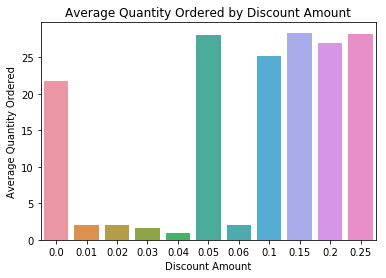

In [9]:
sns.barplot(orders_by_disc['Discount'],orders_by_disc['Quantity'])
plt.xlabel('Discount Amount')
plt.ylabel('Average Quantity Ordered')
plt.title('Average Quantity Ordered by Discount Amount')
plt.show()

In [10]:
orders['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.06       1
0.04       1
Name: Discount, dtype: int64

In [11]:
disc_counts = orders.drop(['OrderId','ProductId','UnitPrice'],axis=1)
disc_counts = disc_counts.groupby(['Discount'],as_index=True).sum()
disc_counts

,Quantity
Discount,
0.00,28599
0.01,2
0.02,4
0.03,5
0.04,1
0.05,5182
0.06,2
0.10,4366
0.15,4456


Ten discount amounts are avaiable, ranging from 1% to 25%. While undiscounted items and those with discounts of 5%, 10%, 15%, 20%, and 25% have over 150 corresponding orders, those with discounts of 1%, 2%, 3%, 4%, or 6% all have just a few orders. Thus, for the purposes below we will either remove these rows entirely, or combine them with the 5% category, as this seems to be a natural and reasonable grouping, especially given the small number of orders with these obscure discount amounts.

For the orders in the former group above (with large numbers of corresponding orders), the average quantity ordered varies slightly, with undiscounted items at the smallest mean of 21.7 items, and those with discounts ranging anywhere from an average quantity of 25.2-28.3, depending on the level of the discount. Across all the orders, over 28,000 undiscounted items and approximately 4000-5000 from each common discount level have been ordered. Below, we remove the less common discount amounts and display the descriptive statistics more clearly.

In [12]:
new_orders_by_disc = orders.drop(['OrderId'],axis=1).groupby(['Discount'],as_index=False).mean()
new_orders_by_disc = new_orders_by_disc.drop([1,2,3,4,6],axis=0)
new_orders_by_disc

,Discount,ProductId,UnitPrice,Quantity
0,0.00,41.396355,26.171534,21.715262
5,0.05,39.518919,30.796324,28.010811
7,0.10,41.410405,25.171561,25.236994
8,0.15,40.452229,22.975924,28.382166
9,0.20,40.031056,23.526770,27.024845
10,0.25,37.792208,28.214416,28.240260


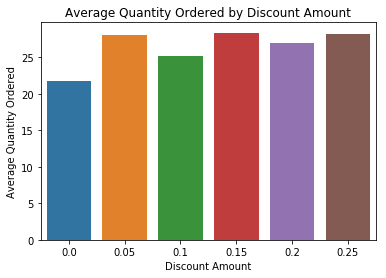

In [13]:
sns.barplot(new_orders_by_disc['Discount'],new_orders_by_disc['Quantity'])
plt.xlabel('Discount Amount')
plt.ylabel('Average Quantity Ordered')
plt.title('Average Quantity Ordered by Discount Amount')
plt.show()

In [14]:
common_disc = orders[orders.Discount.isin([0.00,0.05,0.10,0.15,0.20,0.25])]
common_disc['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

Below, we divide all the existing orders into two categories: 1) discounted, 2) undiscounted. The bar graph below displays the difference in average order quantity for these two categories. At first glance, the difference in means (5.39) appears relatively large and significant at the given scale. Using further analysis, we will demonstrate whether this difference is actually statsitically significant.

In [15]:
no_disc = orders[orders.Discount == 0.00]
disc = orders[orders.Discount != 0.00]

In [16]:
print('Non-Discounted Mean Quantity',no_disc['Quantity'].mean())
print('Discounted Mean Quantity',disc['Quantity'].mean())
print('Difference in Means',disc['Quantity'].mean()-no_disc['Quantity'].mean())

Non-Discounted Mean Quantity 21.715261958997722
Discounted Mean Quantity 27.10978520286396
Difference in Means 5.394523243866239


Text(0.5,1,'Average Quantity for Discounted and Non-Discounted Orders')

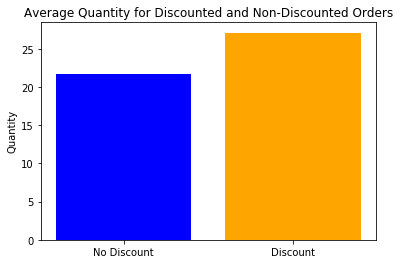

In [17]:
x = ['No Discount', 'Discount']
y = [no_disc['Quantity'].mean(),disc['Quantity'].mean()]
plt.bar(x,y,color=('blue','orange'))
plt.ylabel('Quantity')
plt.title('Average Quantity for Discounted and Non-Discounted Orders')

## Hypothesis Testing for Our Data

In order to answer our question (Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?), we must state our null and alternative hypotheses, generate two distinct groups (control and experimental), and perform a two-sample t-test.

For our question, the null and alternative hypotheses are as follows:

- Ho : no statistically significant difference exists between the quantity of orders with and without a discount.
- Ha : the mean quantity of discounted orders is greater than 21.7 items, the mean for orders without a discount.

Because we are examining only the right side of the non-discounted orders distribution (experimental mean > control mean), this will be a one-tailed t-test.

Before comparing the distributions of discounted/non-discounted items and conducting a two-sample t-test, we first examine the individual distributions and determine whether or not they meet the three conditions needed to perform a two-sample t-test: 1) normality, 2) independence, and 3) randomness.

### Normality

/Users/huntersapienza/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


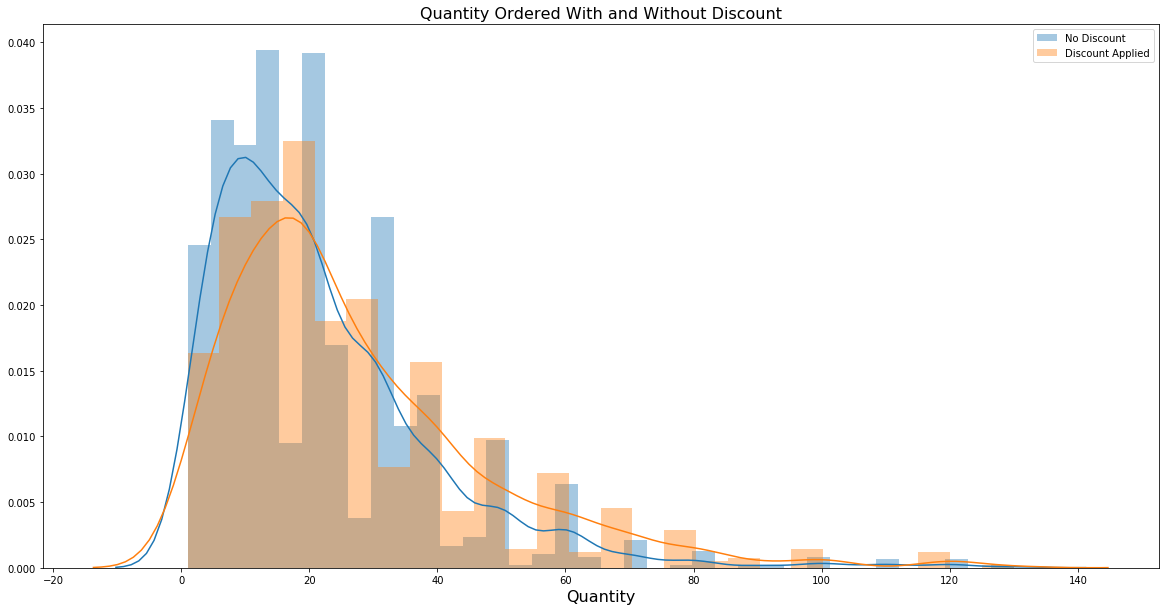

In [18]:
plt.figure(figsize=(20, 10))
sns.distplot(no_disc['Quantity'], label='No Discount')
sns.distplot(disc['Quantity'], label='Discount Applied')
plt.title('Quantity Ordered With and Without Discount', fontsize=16)
plt.xlabel('Quantity', fontsize=16)
plt.legend()
plt.show()

Based on the distributions above, both appear non-normal and heavily skewed right by a few outliers representing abnormally high order quantities. As we noticed in the exploratory statistics, orders of 30 units mark the end of the third quartile for quanitity, but the maximum falls at 130 units. Thus, the high majority or orders consist of less than 30 units, as one can notice in the bulk of the data above, but the rare large orders create outliers that stretch our distributions to the right. Because our distributions are non-normal, we will need to utilize the Central Limit Theorem later by repeatedly sampling the data and creating new distributions by plotting the means of these samples.

In [19]:
from scipy import stats

In [20]:
print('Normality of distribution: ', stats.normaltest(no_disc.Quantity))
print('Normality of distribution: ', stats.normaltest(disc.Quantity))

Normality of distribution:  NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)
Normality of distribution:  NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)


Above, the scipy.stats function for normality generates p-values much lower than our confidence level of 0.05, thus rejecting the null hypothesis (Ho = the distributions are normal) and supporting our alternate hypothesis (Ha = the distributions are not normal).

### Independence

To determine whether independence exists both within and between our two groups, we must consider whether one order affects the next. The quantity ordered by one customer does not affect the quantity ordered by the next, satisfying independence within each group. Furthermore, because the quantity of discounted orders do not directly affect the quantity of quantity of orders without discounts, and vice versa, we can assume that these two distributions are independent of each other, thus satisfying our second condition for the two-sample t-test.

### Randomness

To satisfy the condition for randomness, all samples must have the same probability of being chosen. Since all existing orders are utilzied in our data, and randomly selected using np.random.choice in our distribution of sample means below, we can confidently assume randomness for the two-sample t-test.

### Creating a Distribution of Sample Means Using the CLT to Satisfy Normality

In the following cells, we generate 5000 samples using 500 orders in each sample, and create sample distributions for discounted and non-discounted orders based on the means of these samples. The purpose is to create normal distributions that can be utilized for the two-sample t-test under the assumption of normality.

In [21]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample

def get_sample_mean(sample):
    return sum(sample) / len(sample)

def create_sample_distribution(data, dist_size=100, n=30):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist

/Users/huntersapienza/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


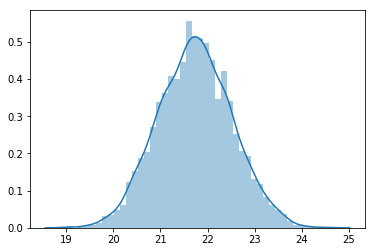

In [22]:
norm_no_disc = create_sample_distribution(no_disc.Quantity,5000,500)
sns.distplot(norm_no_disc)

Our distribution of sample means for non-discounted orders is normal!

/Users/huntersapienza/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


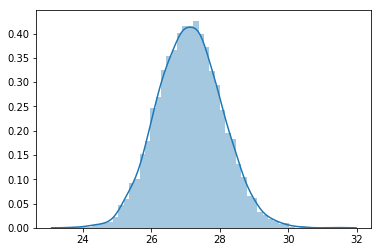

In [23]:
norm_disc = create_sample_distribution(disc.Quantity,5000,500)
sns.distplot(norm_disc)

Our distribution of sample means for discounted orders is also normal!

/Users/huntersapienza/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


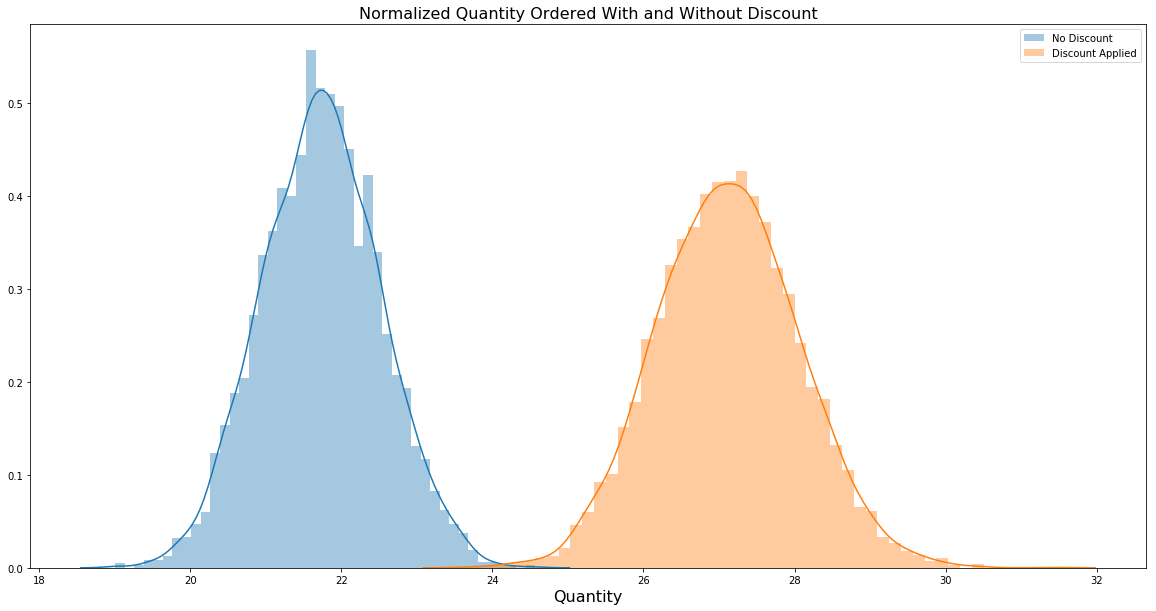

In [24]:
plt.figure(figsize=(20, 10))
sns.distplot(norm_no_disc, label='No Discount')
sns.distplot(norm_disc, label='Discount Applied')
plt.title('Normalized Quantity Ordered With and Without Discount', fontsize=16)
plt.xlabel('Quantity', fontsize=16)
plt.legend()
plt.show()

When we compare the distibutions of sample means for discounted and non-discounted orders, we observe normality for both, as well as very little overlap, indicating that the difference in their means is likely statistically significant. Let's perform a two-sample t-test to find out!

Text(0.5,1,'Average Quantity for Discounted and Non-Discounted Orders')

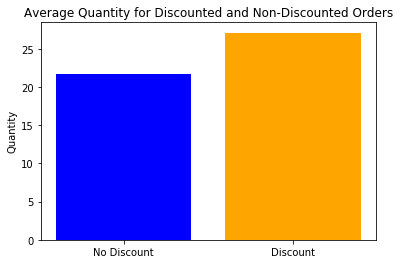

In [25]:
x = ['No Discount', 'Discount']
y = [np.array(norm_no_disc).mean(),np.array(norm_disc).mean()]
plt.bar(x,y,color=('blue','orange'))
plt.ylabel('Quantity')
plt.title('Average Quantity for Discounted and Non-Discounted Orders')

In [26]:
def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    d = diff / np.sqrt(pooled_var)
    
    return d

In [27]:
Cohen_d(np.array(norm_disc),np.array(norm_no_disc))

6.230222781863144

Above, we utilize Cohen's d to quantify the effect size as a measure of the magnitude of difference between discounted and non-discounted orders. As d=0.8 signifies a large effect between our two groups, our result of 6.230 indicates that the difference in means based upon the presence of a discount is very significant and meaningful.

In [28]:
np.var(norm_no_disc) == np.var(norm_disc)

False

In [29]:
from scipy import stats
p = stats.ttest_ind(norm_no_disc, norm_disc, equal_var=False)[1]
p

0.0

In [29]:
p = stats.ttest_ind_from_stats(np.mean(norm_no_disc),np.std(norm_no_disc),len(norm_no_disc),np.mean(norm_disc),np.std(norm_disc),len(norm_disc),equal_var=False)
p

Ttest_indResult(statistic=-311.5111390931572, pvalue=0.0)

**Conclusion:** Our result for the two-sample t-test above indicates that the difference in means is indeed statistically significant, with a p-value much less than 0.05. Thus, we reject the null hypothesis and support our altenative hypothesis that the experimental mean (discounted orders) is larger than 21.7, our control mean (non-discounted orders).

### Difference of Effect Based Upon Discount Size

Below, we compare the quantities of orders at different discount levels to determine whether any signficiant difference exists between these amounts. We start by creating a copy of the orders data and replacing the uncommon discount levels with 0.05. As mentioned earlier, given the small number of orders with these obscure discount amounts, we will combine them with the 5% category, as this seems to be a natural and reasonable grouping.

In [30]:
comp_discounts = orders.copy()

In [31]:
comp_discounts.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10260/41,10260,41,7.7,16,0.25
1,10260/62,10260,62,39.4,15,0.25
2,10260/70,10260,70,12.0,21,0.25
3,10263/16,10263,16,13.9,60,0.25
4,10263/30,10263,30,20.7,60,0.25


In [32]:
comp_discounts.Discount.replace(to_replace=[0.01,0.02,0.03,0.04,0.06], value=0.05, inplace=True)

In [33]:
comp_discounts.Discount.value_counts()

0.00    1317
0.05     193
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

Next, we remove all rows for orders without a discount, as we only want to compare different levels of discount.

In [34]:
comp_discounts= comp_discounts[comp_discounts.Discount!=0.00]

In [35]:
comp_discounts.Discount.value_counts()

0.05    193
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

Below we create a dictionary with each level of discount and its corresponding key containing an array of all the quantities of orders with that particular discount. We will use this data to plot distributions of sample means in comparison ot non-discounted orders below.

In [36]:
five_disc = orders[orders.Discount == 0.05].Quantity
ten_disc = orders[orders.Discount == 0.10].Quantity
fift_disc = orders[orders.Discount == 0.15].Quantity
twen_disc = orders[orders.Discount == 0.20].Quantity
twenfive_disc = orders[orders.Discount == 0.25].Quantity
disc_dict = {'0.05':five_disc, '0.10':ten_disc, '0.15':fift_disc, '0.20':twen_disc, '0.25':twenfive_disc}

/Users/huntersapienza/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


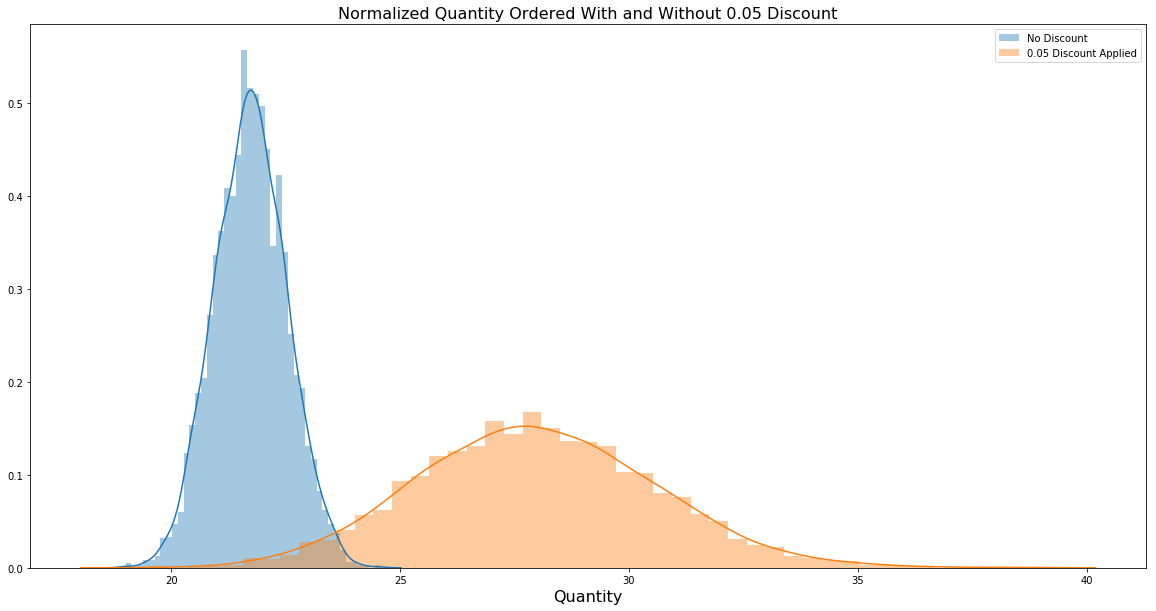

p-value for two-sample t-test:  0.0


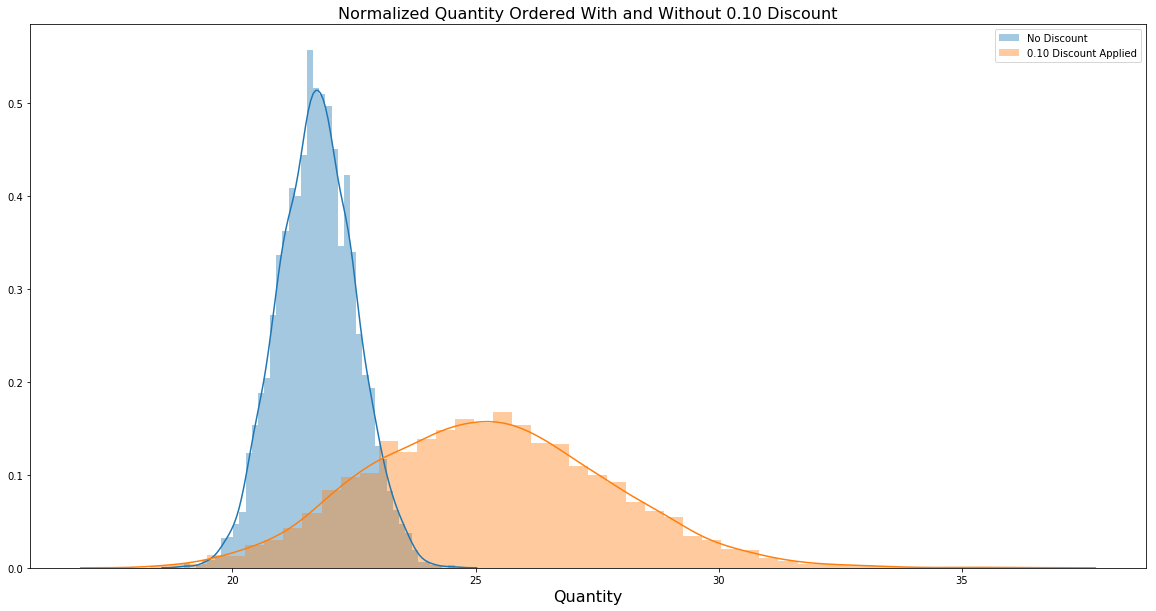

p-value for two-sample t-test:  0.0


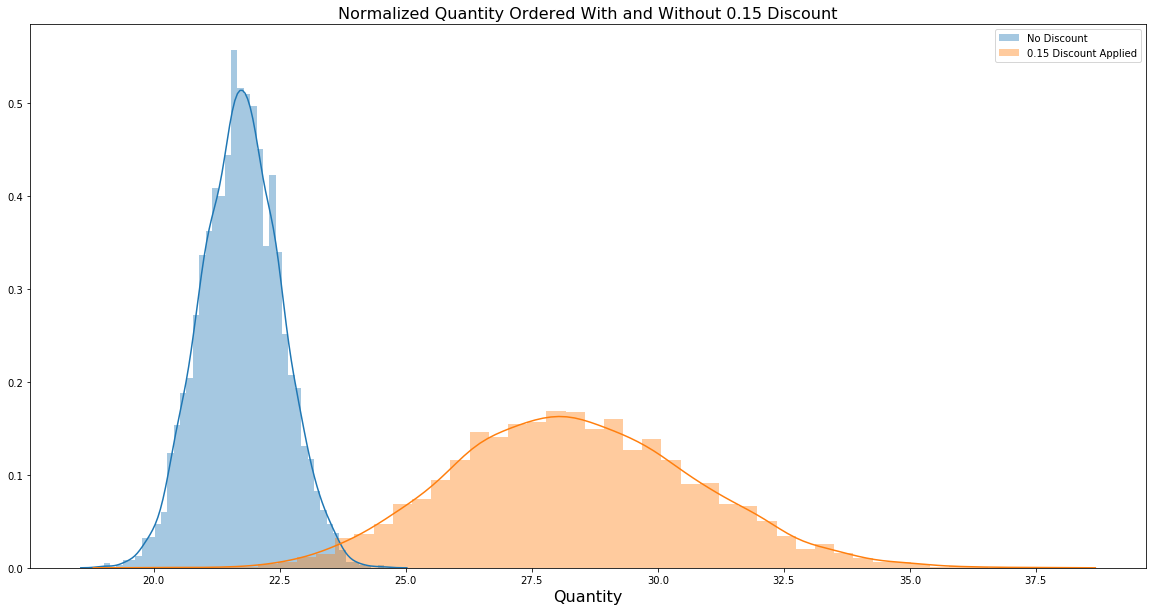

p-value for two-sample t-test:  0.0


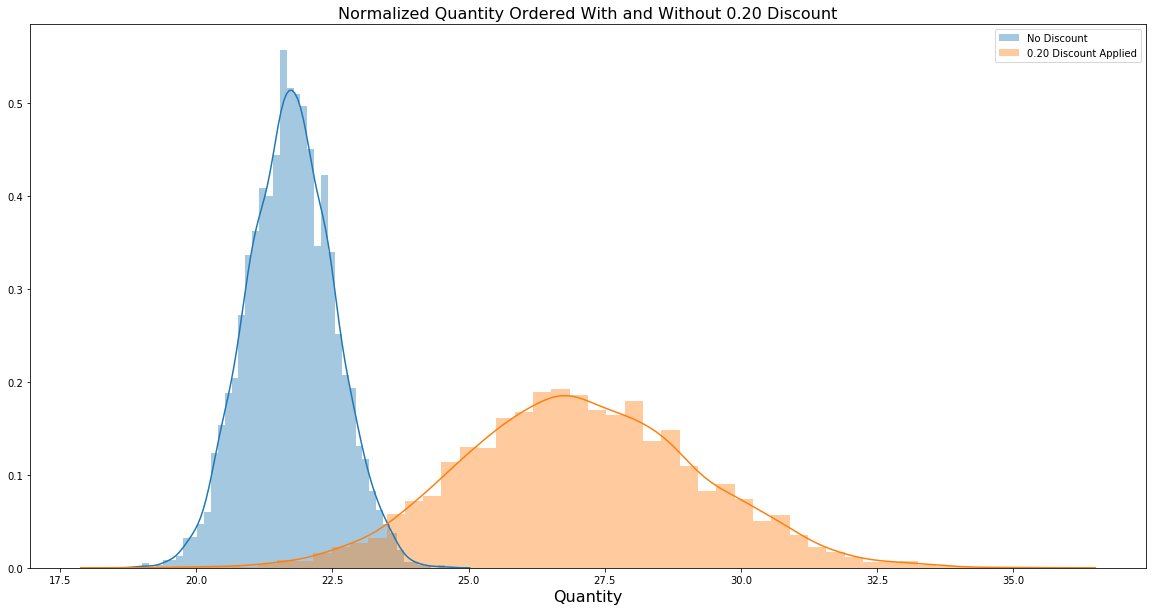

p-value for two-sample t-test:  0.0


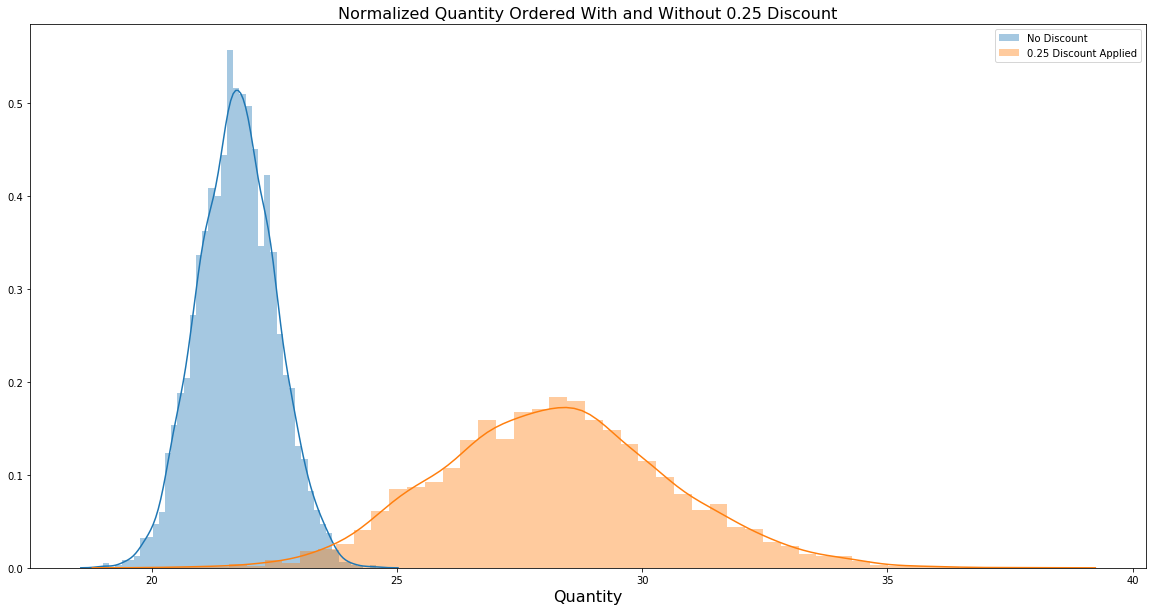

p-value for two-sample t-test:  0.0


In [44]:
for disc in disc_dict:
    data = disc_dict[disc]
    disc_dist = create_sample_distribution(data,5000,75)
    
    plt.figure(figsize=(20, 10))
    sns.distplot(norm_no_disc, label='No Discount')
    sns.distplot(disc_dist, label='{} Discount Applied'.format(disc))
    plt.title('Normalized Quantity Ordered With and Without {} Discount'.format(disc), fontsize=16)
    plt.xlabel('Quantity', fontsize=16)
    plt.legend()
    plt.show()
    
    p = stats.ttest_ind_from_stats(np.mean(norm_no_disc),np.std(norm_no_disc),len(norm_no_disc),np.mean(disc_dist),np.std(disc_dist),len(disc_dist),equal_var=False)[1]*2
    print('p-value for two-sample t-test: ',p)

As we can see from the above distributions, the distribution of sample means for each level of discount has fairly little overlap with the distribution for non-discounted orders (previously used for hypothesis testing above). The p-values for each of the corresponding two-sample t-tests have values lower than 0.05. Thus, we can conclude that orders with each level of discount have higher means than those orders without discounts. Below, we will compare the levels of discounts with each other to determine if any patterns or trends exist in the magnitude of the discount.

Below, we'll create a linear model for discount amount and quantity to determine if any correlation exists between the two variables. First, we designate discount as our predictor and quantity as our target, and normalize/standadize the latter.

In [45]:
X = comp_discounts.Discount
y = comp_discounts.Quantity

y_log = np.log(y)
y_trans = (y_log-np.mean(y_log))/(np.sqrt(np.var(y_log)))

Using a train-test-split, we divide the data and create our initial model using the training data.

In [46]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols

X_train, X_test, y_train, y_test = train_test_split(X,y_trans,test_size=0.2)

X_int = sm.add_constant(X_train)
first_model = sm.OLS(y_train, X_int.astype(float)).fit()
first_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8070
Date:                Sun, 31 Mar 2019   Prob (F-statistic):              0.369
Time:                        13:28:48   Log-Likelihood:                -952.93
No. Observations:                 670   AIC:                             1910.
Df Residuals:                     668   BIC:                             1919.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0770      0.087     -0.888      0.375      -0.247       0.093
Discount       0.4858      0.541      0.898      0.369      -0.576       1.548
==============================================================================
Omnibus:                       51.111   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.574
Skew:                          -0.686   Prob(JB):                     4.26e-14
Kurtosis:                       3.568   Cond. No.                         14.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As one can see, the r-squared value for our model is extremely low and indicates little to no correlation between the magnitude of the discount and the corresponding quantity ordered.

In [47]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
X_train=np.array(X_train).reshape(-1, 1)
X_test=np.array(X_test).reshape(-1, 1)
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 1.0067251897044822
Test Mean Squarred Error: 0.9590292672940797


The MSE values for both the training and test data are low and comparable, indicating that our model is a good fit to our data, although our model does not reveal any interesting trend with regards to differing levels of discounts.

In [48]:
comp_discounts.Quantity.groupby(comp_discounts.Discount).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.05,193.0,26.922280,22.345981,1.0,12.0,20.0,35.0,120.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0
0.20,161.0,27.024845,18.832801,2.0,12.0,21.0,40.0,100.0
0.25,154.0,28.240260,20.120570,2.0,15.0,25.0,36.0,120.0


Finally, we utilize an ANOVA table to test whether discount level is an influential predictor of the quantity ordered. As observed below, the p-value of the F-statistic is 0.395, indicating support for the null hypothesis that changes in discount level do not likely influence the quantity ordered. While we demonstrated above that the presence of a discount increases the average quantity of products ordered, the level of the discount is not as influential.

In [49]:
formula = 'Quantity ~ Discount'
lm = ols(formula, comp_discounts).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq     df         F    PR(>F)
Discount     311.963969    1.0  0.722815  0.395465
Residual  360813.935792  836.0       NaN       NaN


# Additional Hypotheses

In the following sections, we will continue our data exploration and experimental design to answer the following questions:
- How does the region of the supplier affect the average order quantity? What about the customer's region?
- How does the region of the supplier affect the total price of the products ordered? What about the customer's region?
- Does the product category have a statistically significant effect on the unit price of available products? What about the category's effect on the typical details per order (amount saved, quantity, unit price, and discount)?

## Which Products Make the Most Money Over Time?

Below, we obtain data from the product table to analyze the quantity of particular products over time.

In [50]:
cursor.execute('''SELECT * FROM Product''')

products = pd.DataFrame(cursor.fetchall())
products.columns = [i[0] for i in cursor.description]
products.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [51]:
len(products)

77

In [52]:
orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10260/41,10260,41,7.7,16,0.25
1,10260/62,10260,62,39.4,15,0.25
2,10260/70,10260,70,12.0,21,0.25
3,10263/16,10263,16,13.9,60,0.25
4,10263/30,10263,30,20.7,60,0.25


In [53]:
len(orders.ProductId.value_counts())

77

Based on our initial exploration, we observe that 77 total available products exist. We continue by obtaining additional data about all product orders over time. We join our tables based on the product ID in order to further analyze which products produce the most profits across all orders.

In [54]:
cursor.execute('''SELECT OrderDetail.ProductId,OrderDetail.UnitPrice,OrderDetail.Quantity,OrderDetail.Discount,Product.ProductName
FROM OrderDetail
JOIN Product
ON OrderDetail.ProductID=Product.Id''')

ordered_products = pd.DataFrame(cursor.fetchall())
ordered_products.columns = [i[0] for i in cursor.description]
ordered_products.head()

,ProductId,UnitPrice,Quantity,Discount,ProductName
0,11,14.0,12,0.0,Queso Cabrales
1,42,9.8,10,0.0,Singaporean Hokkien Fried Mee
2,72,34.8,5,0.0,Mozzarella di Giovanni
3,14,18.6,9,0.0,Tofu
4,51,42.4,40,0.0,Manjimup Dried Apples


To answer our question, we need to know the total cost for each order. Below, we create a new column 'OrderAmount' by multiplying the quantity by the unit price of the product.

In [55]:
ordered_products['OrderAmount']=ordered_products.Quantity*ordered_products.UnitPrice
ordered_products.head()

,ProductId,UnitPrice,Quantity,Discount,ProductName,OrderAmount
0,11,14.0,12,0.0,Queso Cabrales,168.0
1,42,9.8,10,0.0,Singaporean Hokkien Fried Mee,98.0
2,72,34.8,5,0.0,Mozzarella di Giovanni,174.0
3,14,18.6,9,0.0,Tofu,167.4
4,51,42.4,40,0.0,Manjimup Dried Apples,1696.0


We also calculate how much was discounted from the total cost in a new column 'Discounted_Amount' by multiplying the order amount by the percentage of the cost left after the discount.

In [56]:
ordered_products['Discounted_Amount']=ordered_products.OrderAmount*(1-ordered_products.Discount)

Because we are interested in the totals and averages over time, we create two new dataframes, grouped by product name, with other columns summed in our first dataframe and averaged in the second.

In [57]:
ordered_products.drop(['ProductId'],axis=1,inplace=True)
s_ordered_products=ordered_products.groupby('ProductName').sum()
a_ordered_products=ordered_products.groupby('ProductName').mean()

a_ordered_products.columns=['UnitPrice','AverageQuantity','AverageDiscount','AverageOrderAmount','AverageDiscountedAmount']
s_ordered_products.columns=['UnitPrice','TotalQuantity','TotalDiscount','TotalOrderAmount','TotalDiscountedAmount']

In [58]:
s_ordered_products.drop(['UnitPrice'],axis=1,inplace=True)

In [59]:
s_ordered_products.head()

,TotalQuantity,TotalDiscount,TotalOrderAmount,TotalDiscountedAmount
ProductName,,,,
Alice Mutton,978,2.30,35482.2,32698.380
Aniseed Syrup,328,0.20,3080.0,3044.000
Boston Crab Meat,1103,2.10,19048.3,17910.630
Camembert Pierrot,1577,3.26,50286.0,46825.480
Carnarvon Tigers,539,2.15,31987.5,29171.875


In [60]:
a_ordered_products.head()

,UnitPrice,AverageQuantity,AverageDiscount,AverageOrderAmount,AverageDiscountedAmount
ProductName,,,,,
Alice Mutton,36.470270,26.432432,0.062162,958.978378,883.740000
Aniseed Syrup,9.500000,27.333333,0.016667,256.666667,253.666667
Boston Crab Meat,17.226829,26.902439,0.051220,464.592683,436.844634
Camembert Pierrot,32.133333,30.921569,0.063922,986.000000,918.146667
Carnarvon Tigers,59.722222,19.962963,0.079630,1184.722222,1080.439815


Finally, we concatenate the two tables below so we can compare averages and totals for quantity, discount, order amount, and discounted amount, with the average unit price over time.

In [61]:
final_ordered_products=pd.concat([a_ordered_products,s_ordered_products],axis=1)
final_ordered_products.head()

,UnitPrice,AverageQuantity,AverageDiscount,AverageOrderAmount,AverageDiscountedAmount,TotalQuantity,TotalDiscount,TotalOrderAmount,TotalDiscountedAmount
ProductName,,,,,,,,,
Alice Mutton,36.470270,26.432432,0.062162,958.978378,883.740000,978,2.30,35482.2,32698.380
Aniseed Syrup,9.500000,27.333333,0.016667,256.666667,253.666667,328,0.20,3080.0,3044.000
Boston Crab Meat,17.226829,26.902439,0.051220,464.592683,436.844634,1103,2.10,19048.3,17910.630
Camembert Pierrot,32.133333,30.921569,0.063922,986.000000,918.146667,1577,3.26,50286.0,46825.480
Carnarvon Tigers,59.722222,19.962963,0.079630,1184.722222,1080.439815,539,2.15,31987.5,29171.875


Below, we plot the total profits over time for each product. As illustrated by the graph, we can see that Cote de Blaye (a white wine with the highest unit price of all products) has generated the greatest profits across all orders. Raclette Courdavault and Thüringer Rostbratwurst are also top sellers, generating significantly more profits over time than the average for all products (approximately 17,500 dollars) at over 75,000 dollars. Other notable products are Tarte au sucre, Manjimup Dried Apples, Gnocchi di nonna Alice, and Camembert Pierrot, with total profits of approximately 50,000 dollars. These outliers may be the result of many different factors (high unit price, frequent discounts, etc.), or a combination thereof. 

In the second graph, we plot the average order amount for each product. Although Thüringer Rostbratwurst and Cote de Blaye still prevail as the clear winners in terms of profitability over time, there is otherwise less differentiation between products in this graph than in total order amounts, indicating that most orders may be similar in cost but some products may be ordered more frequently and repeatedly than others, leading to their higher profitability over time.

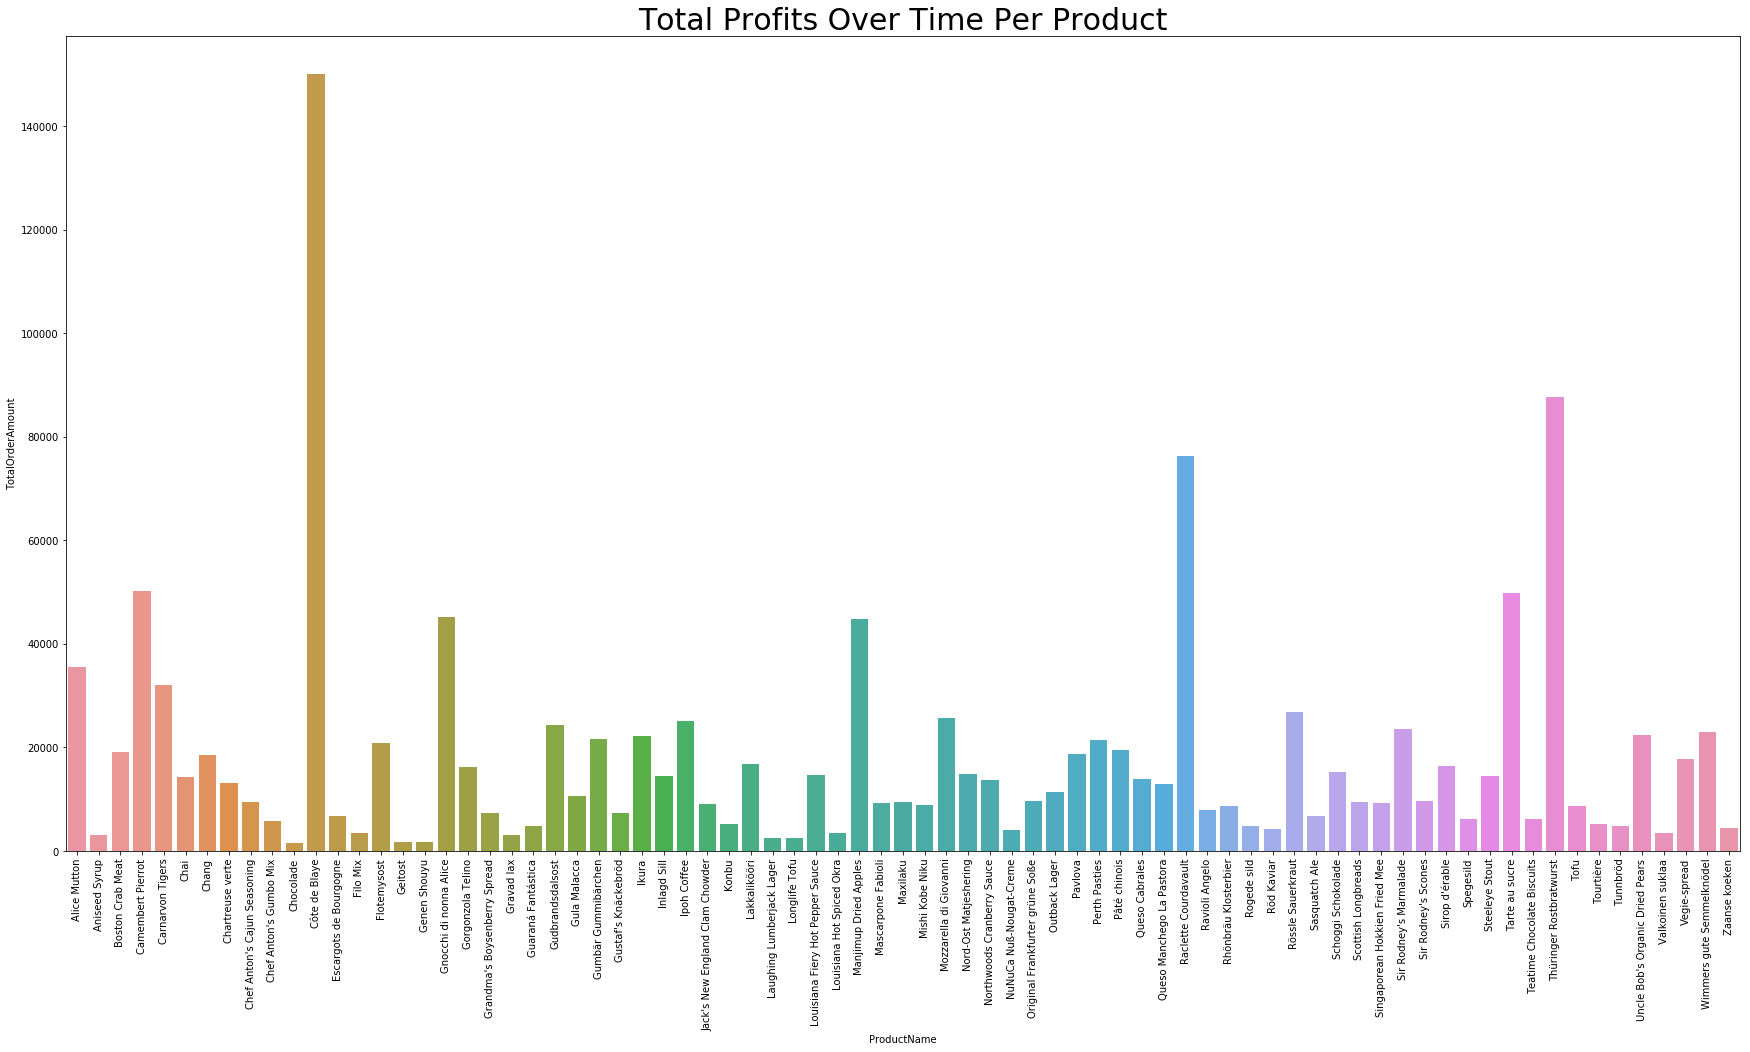

In [62]:
f, ax = plt.subplots(figsize = (30, 15))
sns.barplot(final_ordered_products.index,final_ordered_products['TotalOrderAmount'],ci=False)
plt.xticks(rotation = 90)
plt.title('Total Profits Over Time Per Product',fontsize=30)
plt.show()

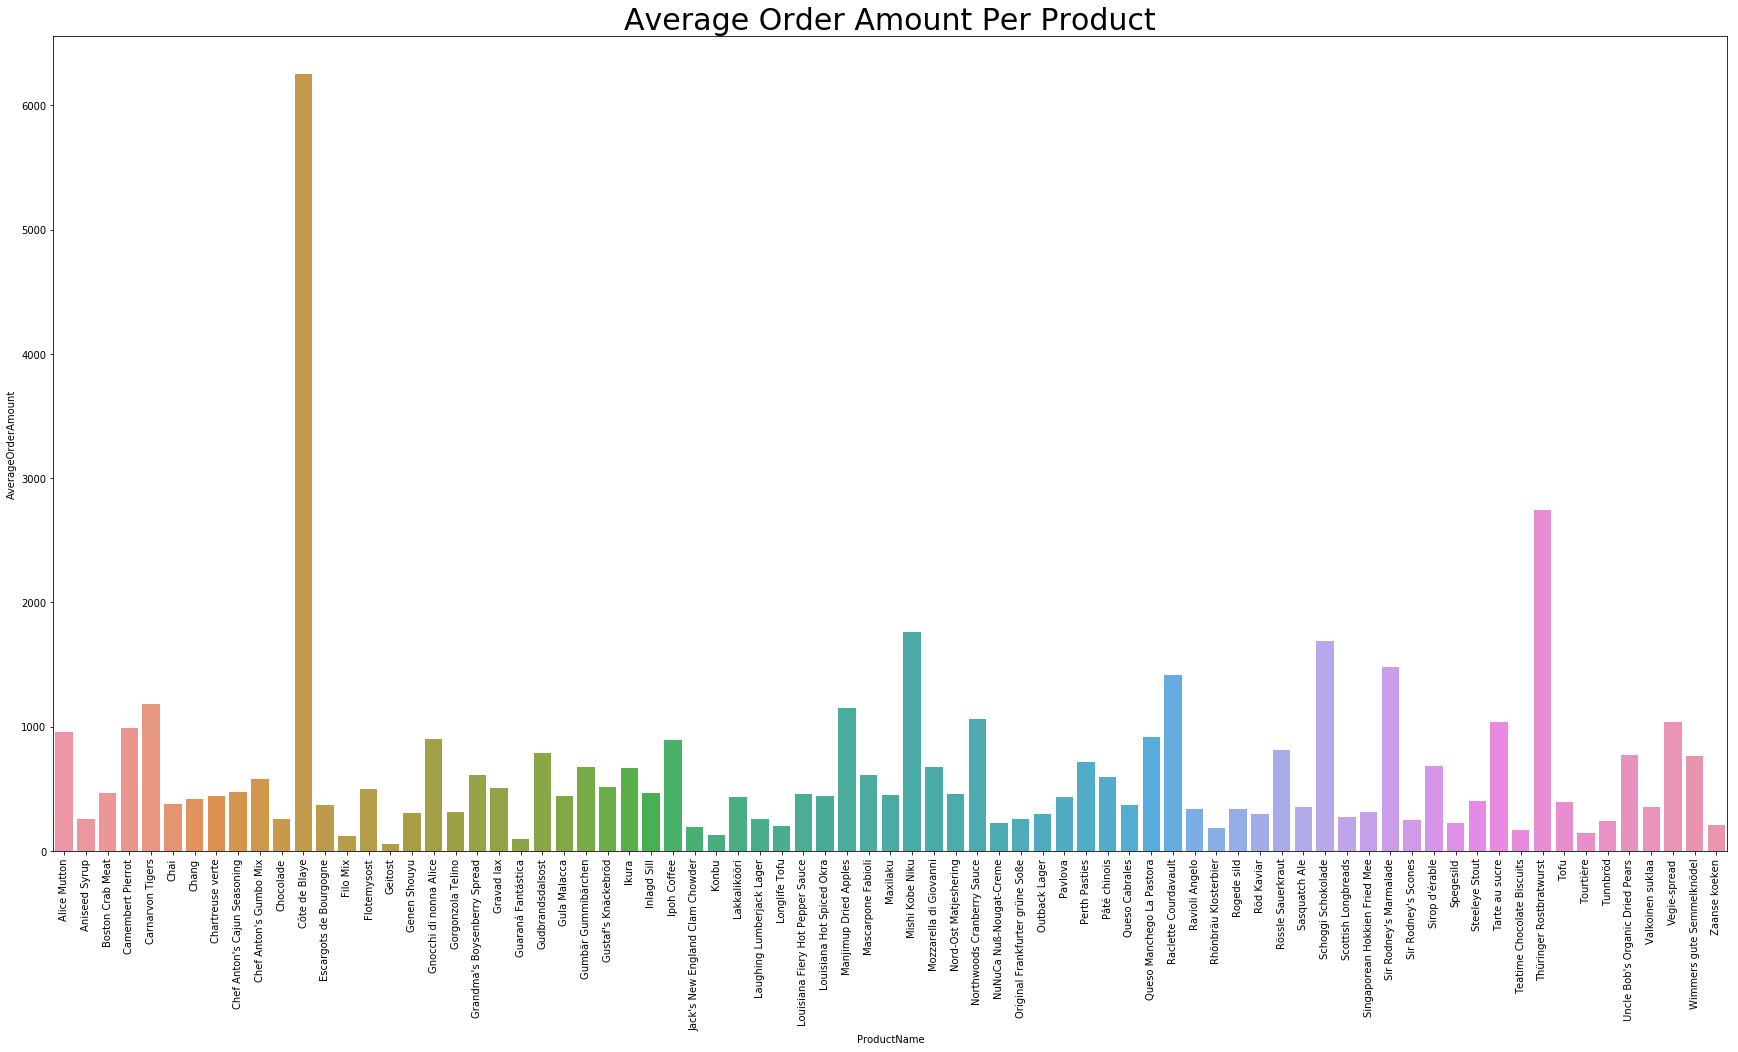

In [63]:
f, ax = plt.subplots(figsize = (30, 15))
sns.barplot(final_ordered_products.index,final_ordered_products['AverageOrderAmount'],ci=False)
plt.xticks(rotation = 90)
plt.title('Average Order Amount Per Product',fontsize=30)
plt.show()

In [64]:
final_ordered_products.reset_index(drop=False,inplace=True)
final_ordered_products.head()

,ProductName,UnitPrice,AverageQuantity,AverageDiscount,AverageOrderAmount,AverageDiscountedAmount,TotalQuantity,TotalDiscount,TotalOrderAmount,TotalDiscountedAmount
0,Alice Mutton,36.470270,26.432432,0.062162,958.978378,883.740000,978,2.30,35482.2,32698.380
1,Aniseed Syrup,9.500000,27.333333,0.016667,256.666667,253.666667,328,0.20,3080.0,3044.000
2,Boston Crab Meat,17.226829,26.902439,0.051220,464.592683,436.844634,1103,2.10,19048.3,17910.630
3,Camembert Pierrot,32.133333,30.921569,0.063922,986.000000,918.146667,1577,3.26,50286.0,46825.480
4,Carnarvon Tigers,59.722222,19.962963,0.079630,1184.722222,1080.439815,539,2.15,31987.5,29171.875


Below, we quickly perform an ANOVA table analysis to see which of the variables in the table above are most influential in determining the profitability of particular products. Based on the results, average unit price is clearly the most influential predictor with a p-value much lower than any other factor. Discount appears to have little to no effect on the profitability of products over time. TotalQuantity is much less influential than unit price, which remains interesting, as TotalOrderAmount is nearly a direct product of the two. Ultimately, we determine that unit price most influences how profitable a product will be over all orders.

In [65]:
formula = 'TotalOrderAmount ~ UnitPrice + AverageQuantity + TotalQuantity + AverageDiscount + TotalDiscount'
lm = ols(formula, final_ordered_products).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                       sum_sq    df           F        PR(>F)
UnitPrice        2.752868e+10   1.0  644.040396  2.442153e-37
AverageQuantity  3.759590e+07   1.0    0.879566  3.515001e-01
TotalQuantity    5.041585e+08   1.0   11.794915  9.953623e-04
AverageDiscount  9.384359e+07   1.0    2.195494  1.428396e-01
TotalDiscount    1.950785e+07   1.0    0.456391  5.015099e-01
Residual         3.034804e+09  71.0         NaN           NaN


## How Does the Region of Suppliers and Customers Affect Order Quantity?

### Supplier Region Effect on Order Quantity

First, we obtain data from the supplier table joined with the product and order detail tables, to determine the quantity of each order and it's corresponding region that it's shipped from.

In [66]:
cursor.execute('''SELECT OrderDetail.OrderId,OrderDetail.ProductId,OrderDetail.Quantity,Product.ProductName,Product.SupplierId,Supplier.Region
FROM Supplier
LEFT JOIN Product
ON Supplier.Id=Product.SupplierId
LEFT JOIN OrderDetail
ON OrderDetail.ProductID=Product.Id''')

supplier_region = pd.DataFrame(cursor.fetchall())
supplier_region.columns = [i[0] for i in cursor.description]
supplier_region.head()

,OrderId,ProductId,Quantity,ProductName,SupplierId,Region
0,10289,3,30,Aniseed Syrup,1,British Isles
1,10405,3,50,Aniseed Syrup,1,British Isles
2,10485,3,20,Aniseed Syrup,1,British Isles
3,10540,3,60,Aniseed Syrup,1,British Isles
4,10591,3,14,Aniseed Syrup,1,British Isles


In [67]:
supplier_region['Region'].value_counts()

Western Europe     447
North America      418
Southern Europe    229
British Isles      220
Scandinavia        175
Victoria           163
Northern Europe    153
Eastern Asia       119
NSW                 98
South-East Asia     82
South America       51
Name: Region, dtype: int64

In [68]:
supplier_region.describe()

,OrderId,ProductId,Quantity,SupplierId
count,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,23.812993,14.488167
std,241.378032,22.159019,19.022047,8.228640
min,10248.000000,1.000000,1.000000,1.000000
25%,10451.000000,22.000000,10.000000,7.000000
50%,10657.000000,41.000000,20.000000,14.000000
75%,10862.500000,60.000000,30.000000,21.000000
max,11077.000000,77.000000,130.000000,29.000000


In [69]:
supplier_region.groupby('Region').SupplierId.value_counts()

Region           SupplierId
British Isles    8             126
                 1              94
Eastern Asia     6              68
                 4              51
NSW              24             98
North America    19             88
                 29             72
                 2              70
                 25             69
                 16             65
                 3              54
Northern Europe  17             51
                 21             41
                 9              34
                 22             27
Scandinavia      15            105
                 23             70
South America    10             51
South-East Asia  20             82
Southern Europe  14            104
                 26             73
                 5              52
Victoria         7             163
Western Europe   12            179
                 28            105
                 11             59
                 18             54
                 13        

By exploring the intial data, we notice that most orders are shipped from suppliers inthe Western Europe and North America regions, with over 400 orders from each. These two regions each have six suppliers, the most of all the regions. The least number of orders are shipped from suppliers in South America, South-East Asia, and New South Wales, with less than 100 orders from each. Each of these three only have one supplier.

In [70]:
s_region_average=supplier_region.groupby('Region',as_index=False).mean()
s_region_average.sort_values('Quantity',inplace=True)

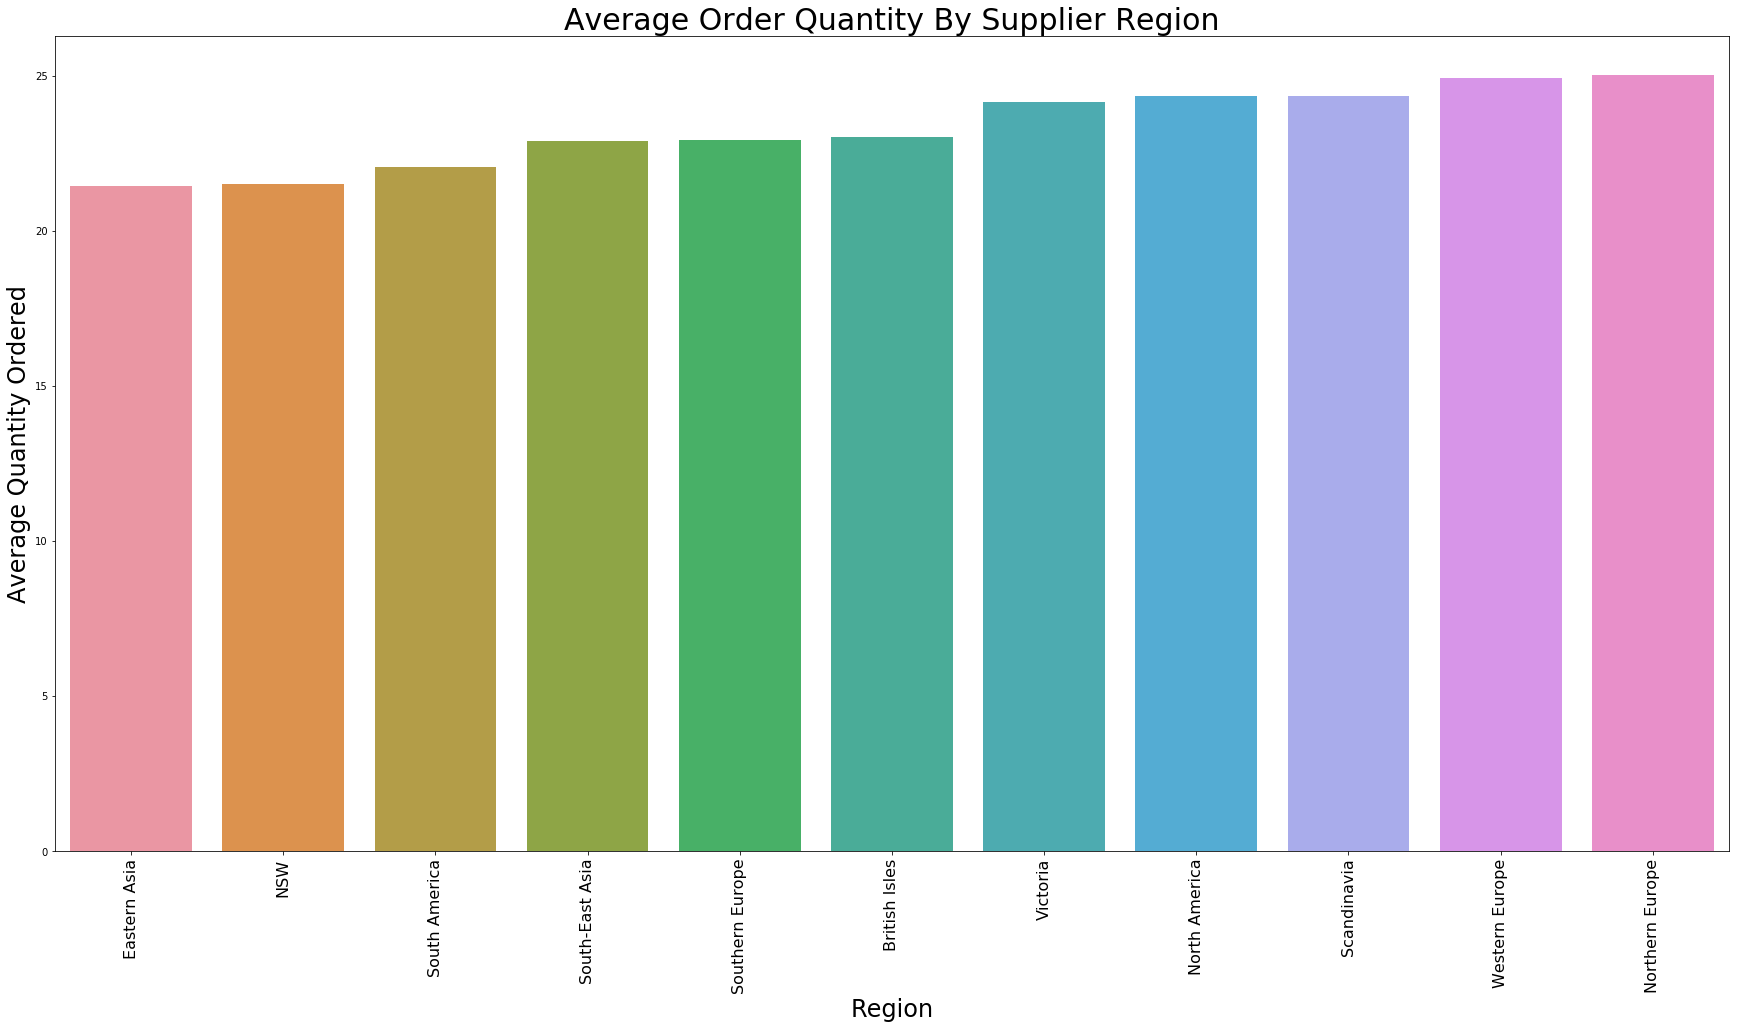

In [71]:
f, ax = plt.subplots(figsize = (30, 15))
sns.barplot(s_region_average.Region,s_region_average.Quantity,ci=False)
plt.xticks(rotation = 90,fontsize=16)
plt.xlabel('Region',fontsize=24)
plt.ylabel('Average Quantity Ordered',fontsize=24)
plt.title('Average Order Quantity By Supplier Region',fontsize=30)
plt.show()

Based on the graph above, the average quantity of orders differs slightly across all regions, with Eastern Asia, NSW, and South America at the lowest average quantity, and Northern/Western Europe at the top. However, it remains unclear whether the supplier region is actually signficantly influential on the average quantity of orders. To determine this degree of influence, we conduct an ANOVA table analysis below.

In [72]:
formula = 'Quantity ~ C(Region)'
lm = ols(formula, supplier_region).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq      df         F    PR(>F)
C(Region)    2708.789747    10.0  0.747742  0.679647
Residual   776690.846448  2144.0       NaN       NaN


The results of our table reveal a p-value of 0.68 for the F-statistic, supporting the null hypothesis and leading us to conclude that the region of the supplier has little to no influence over the quantity of the order.

### Customer Region Effect On Order Quantity

Next, we obtain data from the customer table joined with the order and order detail tables, to determine the quantity of each order and it's corresponding region that it's shipped to.

In [73]:
cursor.execute('''SELECT Customer.Region, OrderDetail.Quantity
             FROM Customer
             LEFT JOIN "Order"
             ON Customer.Id="Order".CustomerId
             LEFT JOIN OrderDetail
             ON "Order".Id=OrderDetail.OrderId;''')

customer_region = pd.DataFrame(cursor.fetchall())
customer_region.columns = [i[0] for i in cursor.description]
customer_region.head()

,Region,Quantity
0,Western Europe,2.0
1,Western Europe,15.0
2,Western Europe,21.0
3,Western Europe,20.0
4,Western Europe,6.0


In [74]:
customer_region.Region.value_counts()

Western Europe     738
North America      427
South America      306
British Isles      190
Northern Europe    143
Southern Europe    138
Scandinavia         70
Central America     56
Eastern Europe      16
Name: Region, dtype: int64

In [75]:
customer_region.describe()

,Quantity
count,2078.000000
mean,23.924447
std,19.151339
min,1.000000
25%,10.000000
50%,20.000000
75%,30.000000
max,130.000000


By exploring the intial data, we notice that most orders are shipped to customers in the Western Europe and North America regions (just like our supplier data), with over 400 orders to the latter and a startling 738 to Western Europe. Based on this data, one might assume that this company primarily caters to European customers and might be a European brand based out of a Western European country. The least number of orders are shipped to customers in Scandinavia, Central America, and Eastern Europe, with less than 100 orders from each. Each of these three only have one supplier.

In [76]:
c_region_average=customer_region.groupby('Region',as_index=False).mean()
c_region_average.sort_values('Quantity',inplace=True)

In [77]:
c_region_average

,Region,Quantity
1,Central America,12.109091
2,Eastern Europe,12.812500
5,Scandinavia,14.942857
7,Southern Europe,15.131387
6,South America,20.917763
0,British Isles,23.294737
4,Northern Europe,23.811189
3,North America,26.496487
8,Western Europe,27.474185


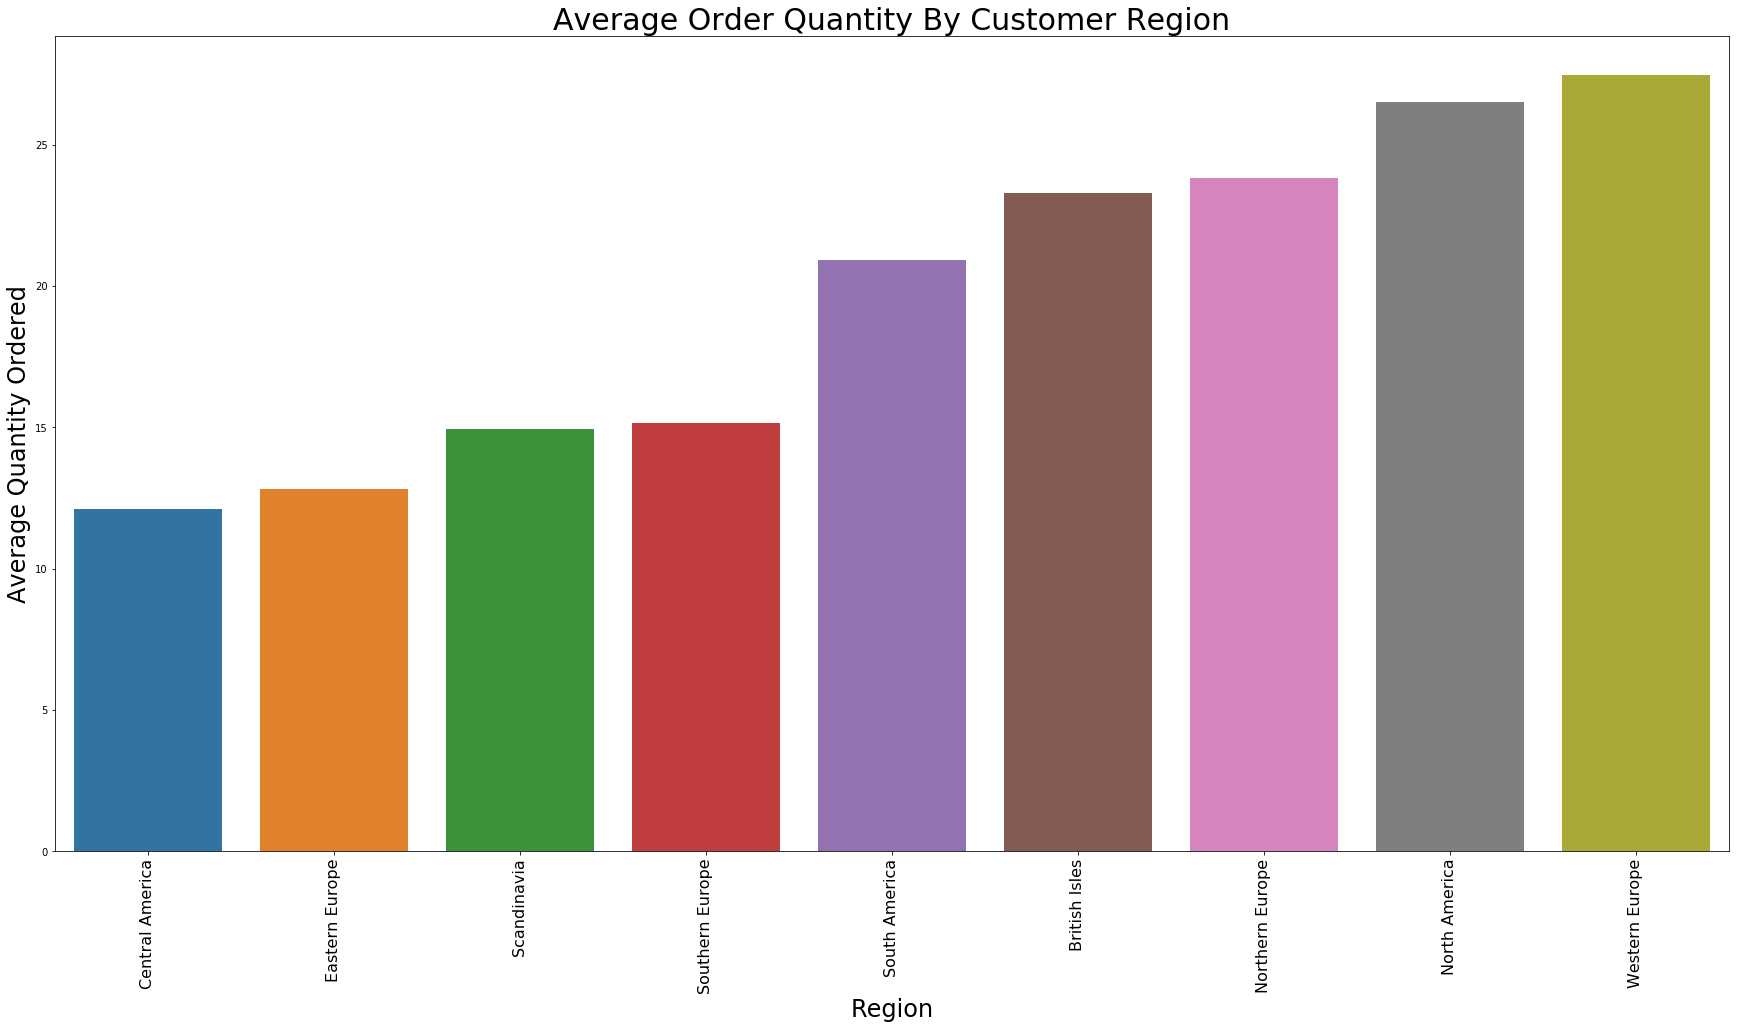

In [78]:
f, ax = plt.subplots(figsize = (30, 15))
sns.barplot(c_region_average.Region,c_region_average.Quantity,ci=False)
plt.xticks(rotation = 90,fontsize=16)
plt.xlabel('Region',fontsize=24)
plt.ylabel('Average Quantity Ordered',fontsize=24)
plt.title('Average Order Quantity By Customer Region',fontsize=30)
plt.show()

By sorting the data by region and finding the mean quantity of each, we notice significant differences in the average quantity depending on the region. With the least number of orders, Scandinavia, Central America, and Eastern Europe also have the lowest average quantity, with under 15 items per order. At the other end of the spectrum, we notice a similar trend, with the same two frontrunners - North America and Western Europe - at the highest average quantity, with both over 25 items per order. The graph and table above illustrate these differences, which appear much more significant than the slight differences we ntoiced in supplier region. Below we conduct an ANOVA table analysis to determine whether customer region is indeed influential in determining the quantity of the order.

In [79]:
formula = 'Quantity ~ C(Region)'
lm = ols(formula, customer_region).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq      df          F        PR(>F)
C(Region)   40817.353539     8.0  14.641888  5.449622e-21
Residual   720971.784575  2069.0        NaN           NaN


The results of our table reveal a very small p-value for the F-statistic, giving us enough evidence to reject the null hypothesis and leading us to conclude that the region of the customer has significant influence over the quantity of the order, with customers in North America and Western Europe typically purchasing more items per order than other regions. Below, we wil perform a similar analysis to determine the effect, if any, of the supplier/customer region on the total price of products ordered.

## Does the Region Affect the Total Price of Products Ordered?

### Supplier Region Effect on Average Total Order Cost

First, we obtain data from the supplier table joined with the product and order detail tables, to determine the unit price and quantity of each order and the corresponding region that it's shipped from.

In [90]:
cursor.execute('''SELECT OrderDetail.UnitPrice,OrderDetail.Quantity,Supplier.Region
FROM Supplier
LEFT JOIN Product
ON Supplier.Id=Product.SupplierId
LEFT JOIN OrderDetail
ON OrderDetail.ProductID=Product.Id''')

supplier_region2 = pd.DataFrame(cursor.fetchall())
supplier_region2.columns = [i[0] for i in cursor.description]
supplier_region2.head()

,UnitPrice,Quantity,Region
0,14.4,10,British Isles
1,14.4,12,British Isles
2,14.4,15,British Isles
3,14.4,15,British Isles
4,14.4,15,British Isles


Next, we create a new column 'Total' by multipyling the unit price of each product by the quantity ordered.

In [91]:
supplier_region2['Total']=supplier_region2.UnitPrice*supplier_region2.Quantity
supplier_region2.head()

,UnitPrice,Quantity,Region,Total
0,14.4,10,British Isles,144.0
1,14.4,12,British Isles,172.8
2,14.4,15,British Isles,216.0
3,14.4,15,British Isles,216.0
4,14.4,15,British Isles,216.0


In [92]:
supplier_region2.Region.value_counts()

Western Europe     447
North America      418
Southern Europe    229
British Isles      220
Scandinavia        175
Victoria           163
Northern Europe    153
Eastern Asia       119
NSW                 98
South-East Asia     82
South America       51
Name: Region, dtype: int64

In [93]:
s_region_average2=supplier_region2.groupby('Region',as_index=False).mean()
s_region_average2.sort_values('Total',inplace=True)
s_region_average2

,Region,UnitPrice,Quantity,Total
6,South America,4.235294,22.058824,93.776471
4,Northern Europe,13.344444,25.032680,331.034314
0,British Isles,17.460909,23.018182,385.048182
1,Eastern Asia,19.714706,21.436975,413.542017
5,Scandinavia,17.949143,24.354286,438.292571
3,North America,21.549163,24.334928,525.702990
7,South-East Asia,24.836585,22.902439,547.997561
8,Southern Europe,24.990830,22.912664,571.093013
9,Victoria,30.132515,24.153374,707.889877
2,NSW,31.351020,21.510204,710.577551


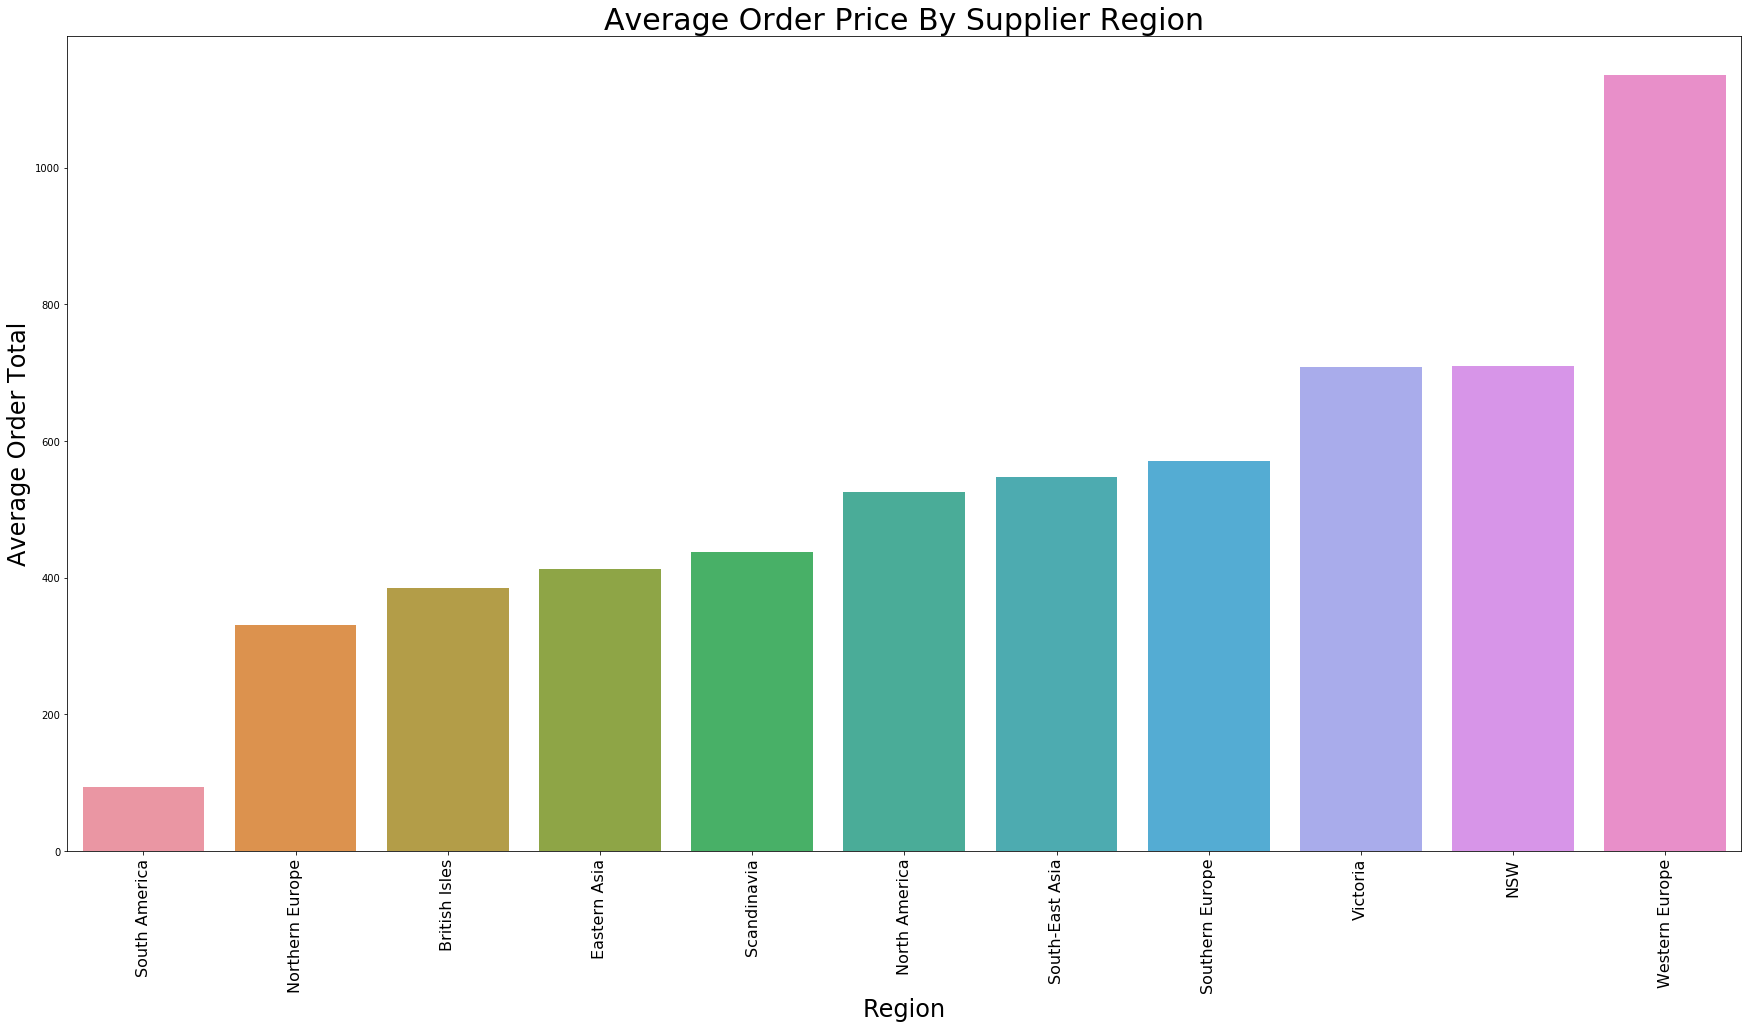

In [94]:
f, ax = plt.subplots(figsize = (30, 15))
sns.barplot(s_region_average2.Region,s_region_average2.Total,ci=False)
plt.xticks(rotation = 90,fontsize=16)
plt.xlabel('Region',fontsize=24)
plt.ylabel('Average Order Total',fontsize=24)
plt.title('Average Order Price By Supplier Region',fontsize=30)
plt.show()

Finally, we create a new dataframe by grouping orders by region and finding the average order total (as well as average unit price) for each. As illustrated by the data above, the average total for South America is much lower than any other region, less than one-third the total for the second lowest average total in Northern Europe. Furthermore, the average total for Western Europe is significantly higher than any other region, over 400 dollars more than the second highest average total in NSW. The average total correlates well with the average unit price for each region, as both follow the same ascending order. The rest of the regions have average totals falling between approximately 300 and 700 dollars. However, it remains unclear whether the supplier region is actually signficantly influential on the average total of orders. To determine this degree of influence, we conduct an ANOVA table analysis below.

In [95]:
formula = 'Total ~ C(Region)'
lm = ols(formula, supplier_region2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq      df         F        PR(>F)
C(Region)  1.756400e+08    10.0  17.61062  3.420949e-31
Residual   2.138324e+09  2144.0       NaN           NaN


The results of our table reveal a very small p-value for the F-statistic, giving us enough evidence to reject the null hypothesis and leading us to conclude that the region of the supplier has significant influence over the total price and profitability of the order, with suppliers in Western Europe typically generating the most profitable orders compared to other regions.

### Customer Region Effect on Average Total Order Price

Next, we obtain data from the customer table joined with the order and order detail tables, to determine the unit price and quantity of each order and it's corresponding region that it's shipped to.

In [96]:
cursor.execute('''SELECT Customer.Region, OrderDetail.Quantity, OrderDetail.UnitPrice
             FROM Customer
             LEFT JOIN "Order"
             ON Customer.Id="Order".CustomerId
             LEFT JOIN OrderDetail
             ON "Order".Id=OrderDetail.OrderId;''')

customer_region2 = pd.DataFrame(cursor.fetchall())
customer_region2.columns = [i[0] for i in cursor.description]
customer_region2.head()

,Region,Quantity,UnitPrice
0,Western Europe,2.0,12.0
1,Western Europe,21.0,18.0
2,Western Europe,15.0,45.6
3,Western Europe,20.0,43.9
4,Western Europe,6.0,10.0


Next, we create a new column 'Total' by multipyling the unit price of each product by the quantity ordered.

In [97]:
customer_region2['Total']=customer_region2.UnitPrice*customer_region2.Quantity
customer_region2.head()

,Region,Quantity,UnitPrice,Total
0,Western Europe,2.0,12.0,24.0
1,Western Europe,21.0,18.0,378.0
2,Western Europe,15.0,45.6,684.0
3,Western Europe,20.0,43.9,878.0
4,Western Europe,6.0,10.0,60.0


In [98]:
customer_region2.Region.value_counts()

Western Europe     738
North America      427
South America      306
British Isles      190
Northern Europe    143
Southern Europe    138
Scandinavia         70
Central America     56
Eastern Europe      16
Name: Region, dtype: int64

In [99]:
c_region_average2=customer_region2.groupby('Region',as_index=False).mean()
c_region_average2.sort_values('Total',inplace=True)
c_region_average2

,Region,Quantity,UnitPrice,Total
2,Eastern Europe,12.812500,20.631250,220.746875
1,Central America,12.109091,26.359091,301.056364
7,Southern Europe,15.131387,22.994234,354.786058
5,Scandinavia,14.942857,27.535429,364.480000
6,South America,20.917763,24.611151,494.132138
0,British Isles,23.294737,25.456474,620.704737
4,Northern Europe,23.811189,25.865245,659.482168
8,Western Europe,27.474185,26.303356,728.362228
3,North America,26.496487,28.970515,746.840937


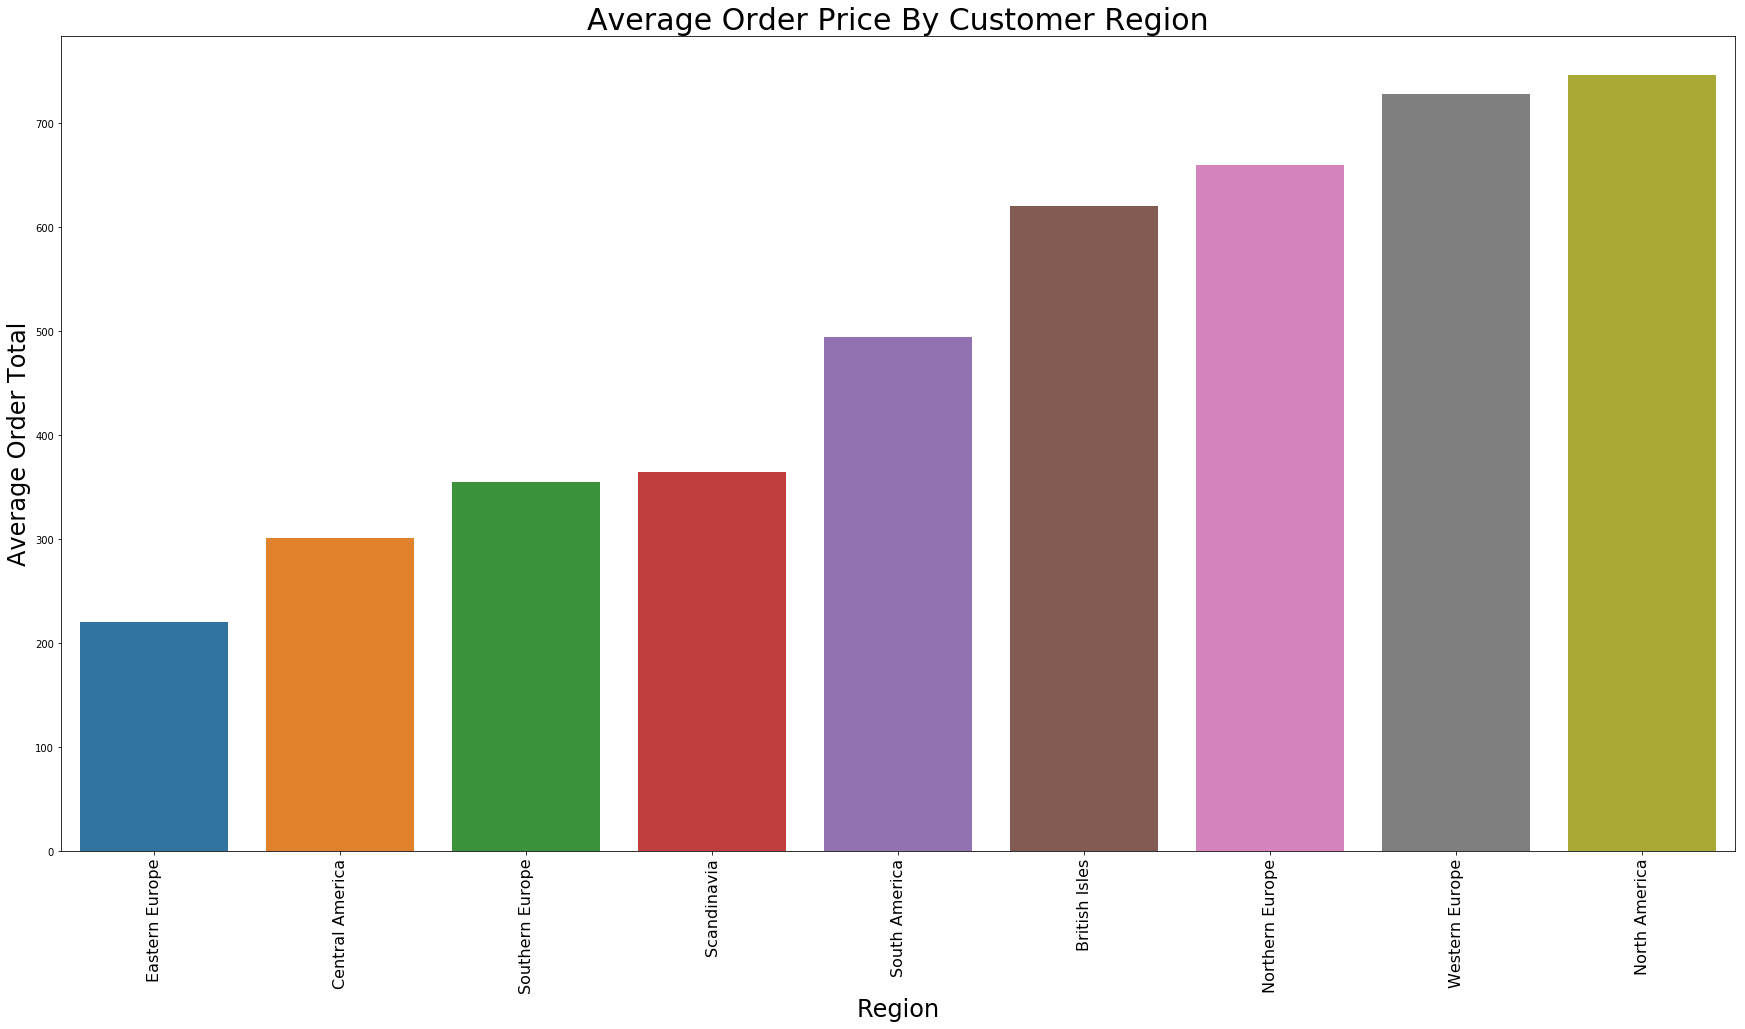

In [100]:
f, ax = plt.subplots(figsize = (30, 15))
sns.barplot(c_region_average2.Region,c_region_average2.Total,ci=False)
plt.xticks(rotation = 90,fontsize=16)
plt.xlabel('Region',fontsize=24)
plt.ylabel('Average Order Total',fontsize=24)
plt.title('Average Order Price By Customer Region',fontsize=30)
plt.show()

Finally, we create a new dataframe by grouping orders by region and finding the average order total (as well as average unit price) for each. As illustrated by the data above, the average total for Eastern Europe is the lowest of all regions, but not as significantly lower as the averages for supplier region. Furthermore, the average total for North American and Western Europe are higher than any other region, but also not as significantly as with supplier region. The average total does not correlate as well with the average unit price for each region, as both follow the different ascending orders. The rest of the regions have average totals falling between approximately 300 and 650 dollars. At first glance, it appears that customer region has a much lower influence on average total than our previous findings of supplier region. However, it remains unclear whether the customer region is actually signficantly influential on the average total of orders. To determine this degree of influence, we conduct an ANOVA table analysis below.

In [101]:
formula = 'Total ~ C(Region)'
lm = ols(formula, customer_region2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq      df         F    PR(>F)
C(Region)  4.264262e+07     8.0  5.030355  0.000003
Residual   2.192379e+09  2069.0       NaN       NaN


The results of our table reveal a p-value smaller than 0.05 for the F-statistic, giving us enough evidence to reject the null hypothesis and leading us to conclude that the region of the customer has significant influence over the total price and profitability of the order, with customers in North America and Western Europe typically generating the most profitable orders compared to other regions. However, this influence is not as significant as supplier region's effect on total price.

## Product Category Effect on Order Details

### How Does the Product Category Affect Unit Price of Available Products?

First, we obtain data from the product table joined with the category table, to determine the unit price of each product and the corresponding category type.

In [102]:
cursor.execute('''SELECT Product.ProductName,Category.CategoryName,Product.UnitPrice
FROM Product
LEFT JOIN Category
ON Product.CategoryId=Category.Id''')

product_categories = pd.DataFrame(cursor.fetchall())
product_categories.columns = [i[0] for i in cursor.description]
product_categories.head()

,ProductName,CategoryName,UnitPrice
0,Chai,Beverages,18.00
1,Chang,Beverages,19.00
2,Aniseed Syrup,Condiments,10.00
3,Chef Anton's Cajun Seasoning,Condiments,22.00
4,Chef Anton's Gumbo Mix,Condiments,21.35


In [103]:
product_categories.describe()

,UnitPrice
count,77.000000
mean,28.866364
std,33.815111
min,2.500000
25%,13.250000
50%,19.500000
75%,33.250000
max,263.500000


In [104]:
product_categories.CategoryName.value_counts()

Confections       13
Beverages         12
Seafood           12
Condiments        12
Dairy Products    10
Grains/Cereals     7
Meat/Poultry       6
Produce            5
Name: CategoryName, dtype: int64

Based on our first exploration of this data, we notice that there are eight categories for the 77 products avaiable. The unit price of products ranges from 2.50 to 263.50, with an average of 28.86 and the majority of products at prices less than 35 dollars.

In [105]:
product_categories.drop(['ProductName'],axis=1,inplace=True)

In [106]:
mean_by_category = product_categories.groupby('CategoryName',as_index=False).mean()
mean_by_category.sort_values('UnitPrice',inplace=True)
mean_by_category

,CategoryName,UnitPrice
4,Grains/Cereals,20.250000
7,Seafood,20.682500
1,Condiments,23.062500
2,Confections,25.160000
3,Dairy Products,28.730000
6,Produce,32.370000
0,Beverages,37.979167
5,Meat/Poultry,54.006667


By grouping the products by category and sorting based on ascending unit price, we notice that meats and poultry cost significantly more on average than any other category, with an average unit price of 54 dollars. While beverages is also slightly higher at an average unit price of almost 38 dollars, all other categories have averages between 20 and 35 dollors. At first glance, it appears that the catergory may have a significant influence on the average unit price. To determine this degree of influence, we conduct an ANOVA table analysis below.

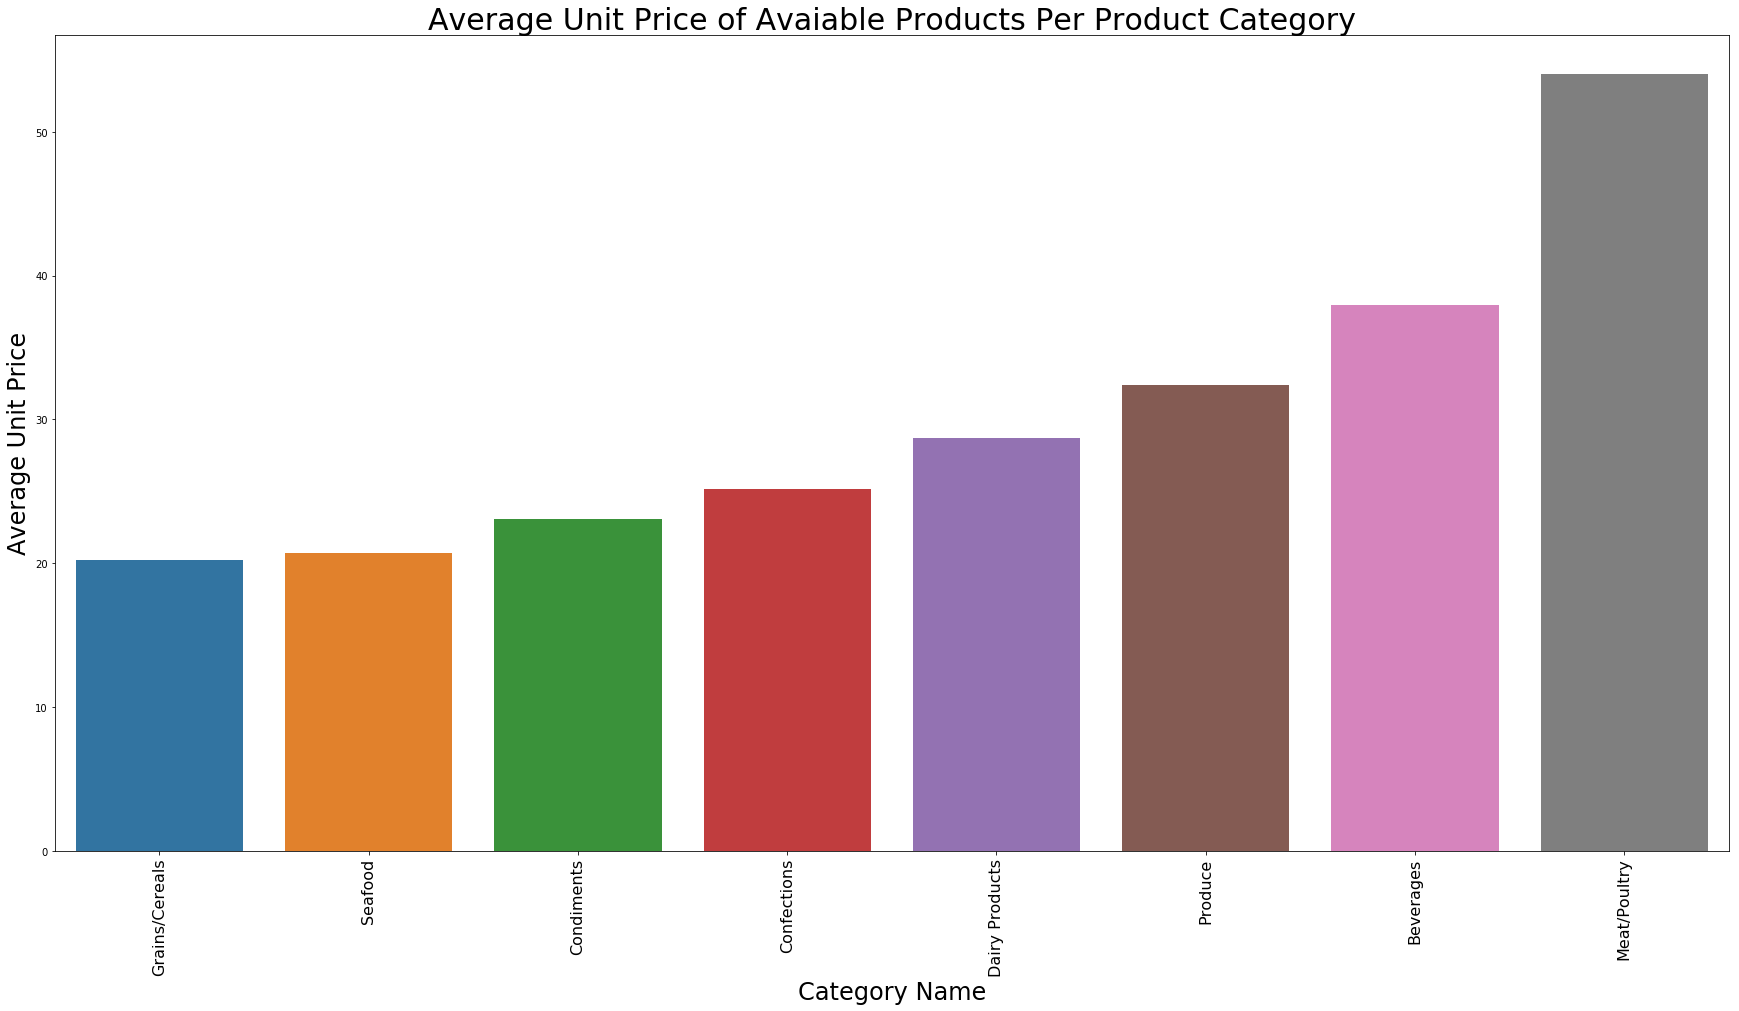

In [107]:
f, ax = plt.subplots(figsize = (30, 15))
sns.barplot(mean_by_category.CategoryName,mean_by_category.UnitPrice,ci=False)
plt.xticks(rotation = 90,fontsize=16)
plt.xlabel('Category Name',fontsize=24)
plt.ylabel('Average Unit Price',fontsize=24)
plt.title('Average Unit Price of Avaiable Products Per Product Category',fontsize=30)
plt.show()

In [108]:
formula = 'UnitPrice ~ C(CategoryName)'
lm = ols(formula, product_categories).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                       sum_sq    df         F    PR(>F)
C(CategoryName)   6756.490707   7.0  0.830973  0.565251
Residual         80146.603275  69.0       NaN       NaN


Based upon our ANOVA table analysis, it appears that category does not have a statistically significant influence on the unit price of available products. With a p-value of 0.565 for our F-statistic, we support our null hypothesis that the unit price is not significantly different between categories. However, below, we will explore all orders over time to determine whether category is an influential predictor of typical order values over time.

### How Does the Product Category Affect the Typical Order Value?

Similarly to our last hypothesis, we gather data based upon the category name, but this time we pull data from all existing orders, including unit price, quantity, and discount.

In [109]:
cursor.execute('''SELECT Product.ProductName,Category.CategoryName,OrderDetail.OrderId,OrderDetail.UnitPrice,OrderDetail.Quantity,OrderDetail.Discount
FROM Category
LEFT JOIN Product
ON Product.CategoryId=Category.Id
LEFT JOIN OrderDetail
ON Product.Id=OrderDetail.ProductId''')

category_orders = pd.DataFrame(cursor.fetchall())
category_orders.columns = [i[0] for i in cursor.description]
category_orders.head()

,ProductName,CategoryName,OrderId,UnitPrice,Quantity,Discount
0,Chai,Beverages,10285,14.4,45,0.20
1,Chai,Beverages,10294,14.4,18,0.00
2,Chai,Beverages,10317,14.4,20,0.00
3,Chai,Beverages,10348,14.4,15,0.15
4,Chai,Beverages,10354,14.4,12,0.00


In [110]:
category_orders.CategoryName.value_counts()

Beverages         404
Dairy Products    366
Confections       334
Seafood           330
Condiments        216
Grains/Cereals    196
Meat/Poultry      173
Produce           136
Name: CategoryName, dtype: int64

In [111]:
category_orders.drop('OrderId',axis=1).describe()

,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000
mean,26.218520,23.812993,0.056167
std,29.827418,19.022047,0.083450
min,2.000000,1.000000,0.000000
25%,12.000000,10.000000,0.000000
50%,18.400000,20.000000,0.000000
75%,32.000000,30.000000,0.100000
max,263.500000,130.000000,0.250000


After gathering our data, we conduct several ANOVA table analyses to determine which target variables the category has significant influence over. Our results are summarized at the bottom.

In [112]:
formula = 'UnitPrice ~ C(ProductName)'
lm = ols(formula, category_orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq      df            F  PR(>F)
C(ProductName)  1.883430e+06    76.0  1563.838285     0.0
Residual        3.292983e+04  2078.0          NaN     NaN


In [113]:
formula = 'UnitPrice ~ C(CategoryName)'
lm = ols(formula, category_orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                       sum_sq      df         F        PR(>F)
C(CategoryName)  9.413697e+04     7.0  15.84502  2.097109e-20
Residual         1.822223e+06  2147.0       NaN           NaN


In [114]:
formula = 'Quantity ~ C(CategoryName)'
lm = ols(formula, category_orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                        sum_sq      df         F    PR(>F)
C(CategoryName)    1292.377084     7.0  0.509429  0.828058
Residual         778107.259110  2147.0       NaN       NaN


In [115]:
formula = 'Discount ~ C(CategoryName)'
lm = ols(formula, category_orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F    PR(>F)
C(CategoryName)   0.074918     7.0  1.539545  0.149326
Residual         14.925422  2147.0       NaN       NaN


While the unit price is significantly influenced by both product name and category type, with p-values of 0.0 and 2.097e-20 respectively, it appears that category has a much more significant influence over the unit price than product. Due to our findings in the previous section, this is especially interesting as it appears that category does not have signficant influence over unit price for avaiable products, but does for the unit price of products ordered over time. Below, we will plot and explore this further.

Category does not significantly influence quantity and discount. With p-values of 0.828 and 0.149 for the F-statistics, we support the null hypothesis and conclude that quantity and discount are not significantly different between categories. However, we will create an additional column 'AmountSaved, by finding the product of each order's unit price, quantity, and discount. Below, we will see if any difference exists in the amount saved for different categories. 

In [116]:
category_orders['AmountSaved']=category_orders.UnitPrice*category_orders.Quantity*category_orders.Discount
category_orders.head()

,ProductName,CategoryName,OrderId,UnitPrice,Quantity,Discount,AmountSaved
0,Chai,Beverages,10285,14.4,45,0.20,129.6
1,Chai,Beverages,10294,14.4,18,0.00,0.0
2,Chai,Beverages,10317,14.4,20,0.00,0.0
3,Chai,Beverages,10348,14.4,15,0.15,32.4
4,Chai,Beverages,10354,14.4,12,0.00,0.0


In [117]:
formula = 'AmountSaved ~ C(CategoryName)'
lm = ols(formula, category_orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                       sum_sq      df         F    PR(>F)
C(CategoryName)  5.287607e+05     7.0  4.251642  0.000113
Residual         3.814489e+07  2147.0       NaN       NaN


Based on our ANOVA table above, with a p-value of 0.000113 for our F-statistic, we reject our null hypothesis and conclude that the amount saved is signficantly different depending on the category type.

Below, we explore further our two significant observations: differences between categories in 1) amount saved and 2) unit price. 

### Differences in Amount Saved per Category

To further explore the differences in the amount saved between product categories, we take the data from the previous section and group it by category, with other variables averaged for each. Then, we sort by the amount saved in ascending order to make the results visually clear. See the graph below for the results!

In [118]:
category_orders_summary = category_orders.groupby('CategoryName',as_index=False).mean()
category_orders_summary.sort_values('AmountSaved',inplace=True)
category_orders_summary

,CategoryName,OrderId,UnitPrice,Quantity,Discount,AmountSaved
4,Grains/Cereals,10663.974490,21.246429,23.275510,0.045306,25.419452
2,Confections,10651.035928,22.602695,23.670659,0.056946,29.167290
7,Seafood,10675.957576,19.062970,23.275758,0.060242,31.398038
1,Condiments,10664.375000,21.320833,24.527778,0.052639,35.405856
6,Produce,10665.448529,35.194485,21.985294,0.045441,38.853088
3,Dairy Products,10640.639344,26.983060,24.997268,0.053443,45.965068
0,Beverages,10673.623762,29.236757,23.594059,0.061881,46.185074
5,Meat/Poultry,10633.988439,42.874740,24.271676,0.064451,87.667286


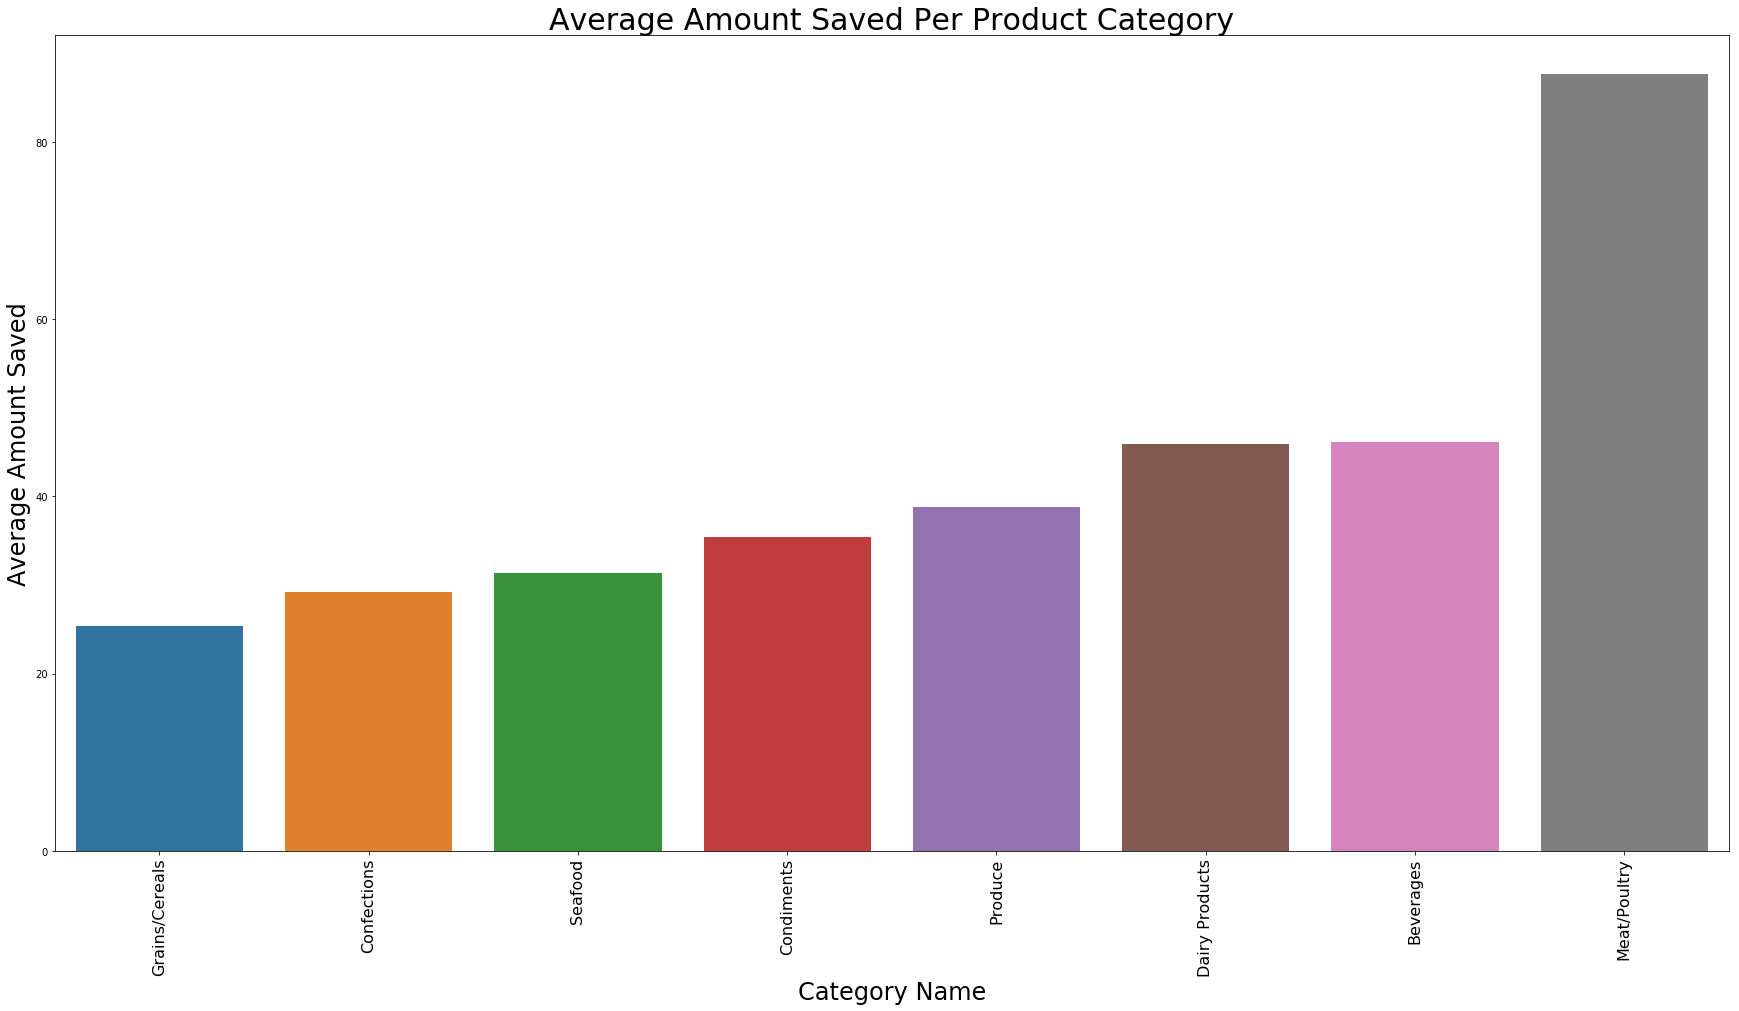

In [119]:
f, ax = plt.subplots(figsize = (30, 15))
sns.barplot(category_orders_summary.CategoryName,category_orders_summary.AmountSaved,ci=False)
plt.xticks(rotation = 90,fontsize=16)
plt.xlabel('Category Name',fontsize=24)
plt.ylabel('Average Amount Saved',fontsize=24)
plt.title('Average Amount Saved Per Product Category',fontsize=30)
plt.show()

Based on the ANOVA table analysis above, we can confirm with enough evidence to reject the null hypothesis that the differences in the average amount saved between product categories is indeed significant. Above, we observe that the mean for meat/poultry orders is 87.67 saved, a staggering 40 dollars more than any other category!

### Differences in Unit Price of Ordered Products per Category

Below, we also explore further our findings from above about the significance of differences in unit price of products orders based on product category. By observing the graph below, it is clear that some differences exist when compared to the graph of amount saved per category (especially with the average unit price for produce orders rising above many of the other categories). However, meat/poultry is still clearly the front runner here. In the remainder of this section, we also test the hypothesis that average unit prices for meat/poultry orders is indeed significantly larger than all the other categories.

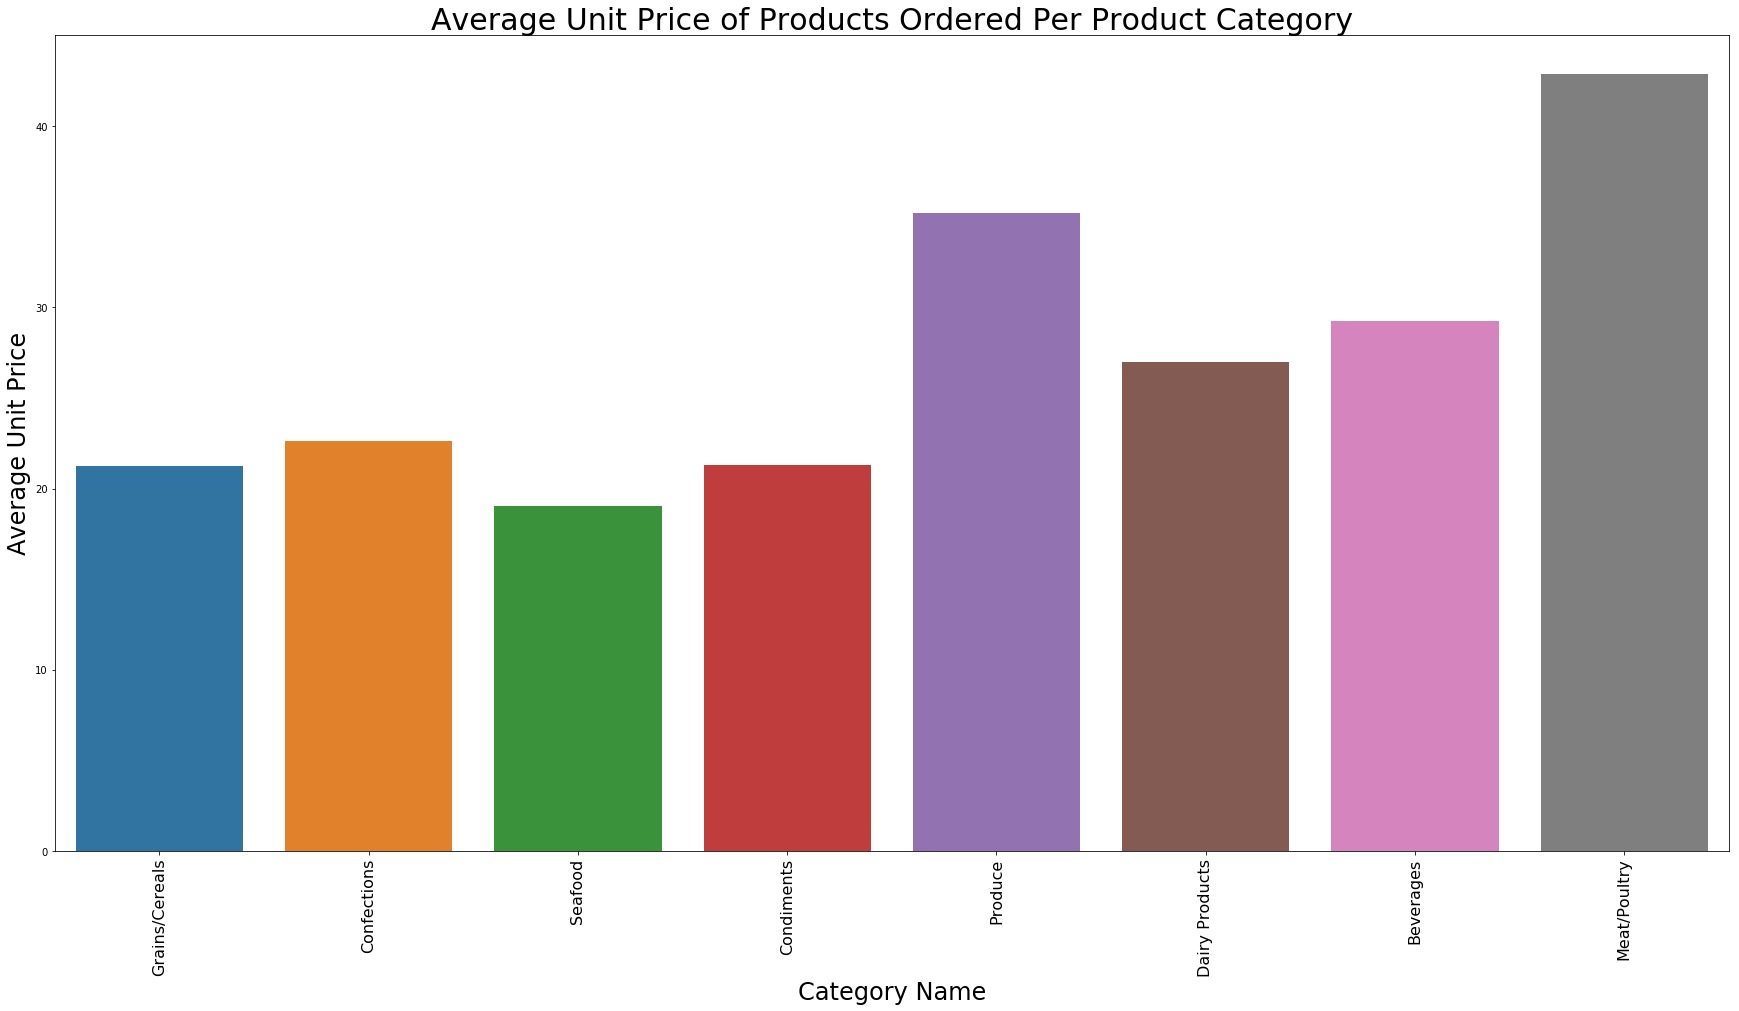

In [120]:
f, ax = plt.subplots(figsize = (30, 15))
sns.barplot(category_orders_summary.CategoryName,category_orders_summary.UnitPrice,ci=False)
plt.xticks(rotation = 90,fontsize=16)
plt.xlabel('Category Name',fontsize=24)
plt.ylabel('Average Unit Price',fontsize=24)
plt.title('Average Unit Price of Products Ordered Per Product Category',fontsize=30)
plt.show()

To test whether the average unit prices for meat/poultry orders is significantly larger than all other categories, we separate the data into two groups, control (other_categories) and experimental (meat_poultry), normalize the dataframes by creating distributions of sample means, and then conduct a two-sample t-test to compare the two groups.

In [121]:
meat_poultry = category_orders[category_orders.CategoryName == 'Meat/Poultry'].UnitPrice
other_categories = category_orders[category_orders.CategoryName != 'Meat/Poultry'].UnitPrice

/Users/huntersapienza/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


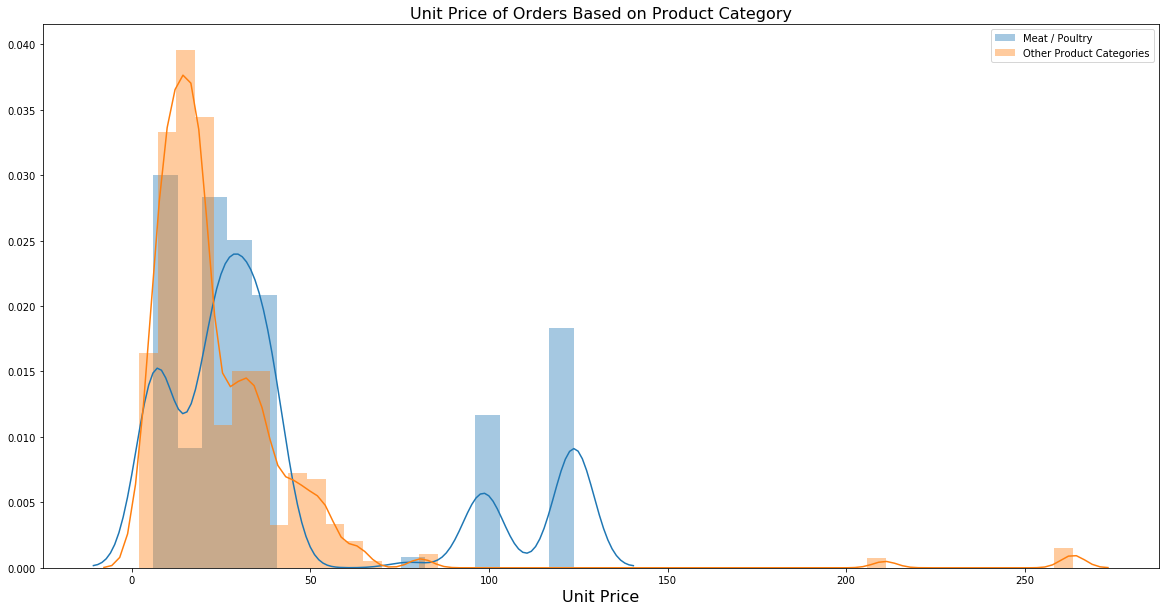

In [122]:
plt.figure(figsize=(20, 10))
sns.distplot(meat_poultry, label='Meat / Poultry')
sns.distplot(other_categories, label='Other Product Categories')
plt.title('Unit Price of Orders Based on Product Category', fontsize=16)
plt.xlabel('Unit Price', fontsize=16)
plt.legend()
plt.show()

/Users/huntersapienza/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


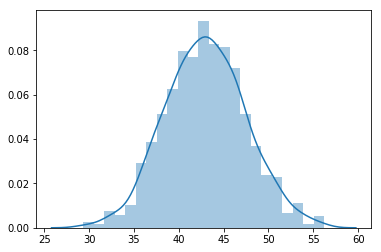

In [123]:
norm_meat = create_sample_distribution(meat_poultry,1000,75)
sns.distplot(norm_meat)

/Users/huntersapienza/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


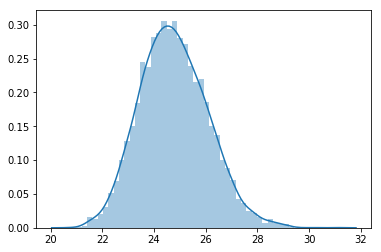

In [124]:
norm_other_categories = create_sample_distribution(other_categories,5000,500)
sns.distplot(norm_other_categories)

/Users/huntersapienza/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


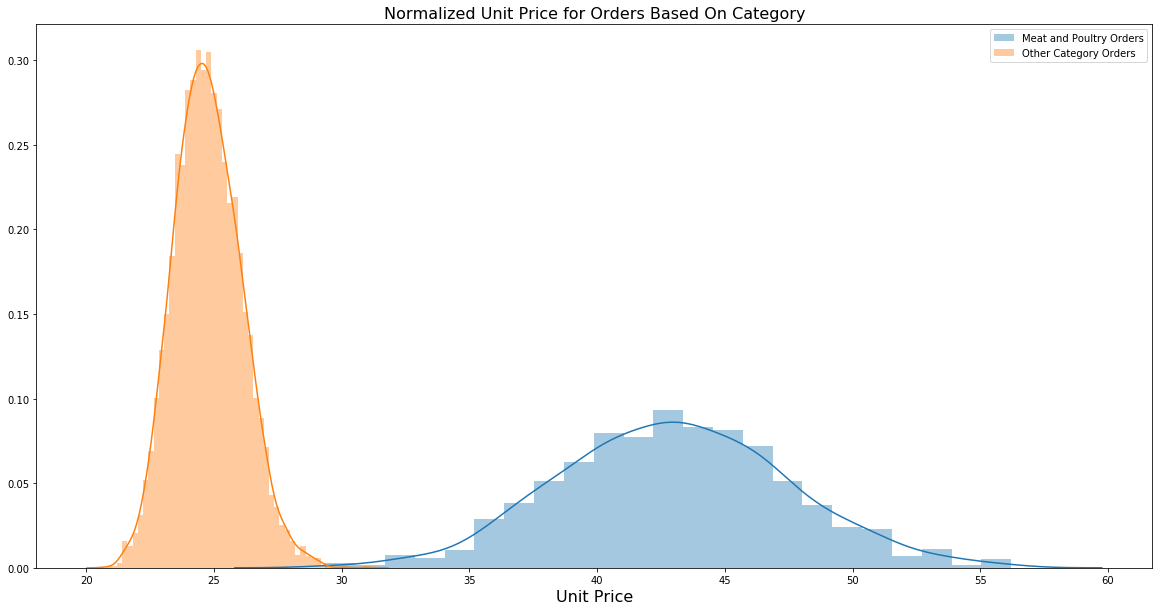

In [125]:
plt.figure(figsize=(20, 10))
sns.distplot(norm_meat, label='Meat and Poultry Orders')
sns.distplot(norm_other_categories, label='Other Category Orders')
plt.title('Normalized Unit Price for Orders Based On Category', fontsize=16)
plt.xlabel('Unit Price', fontsize=16)
plt.legend()
plt.show()

In [126]:
p = stats.ttest_ind(norm_meat, norm_other_categories, equal_var=False)[1]
p

0.0

In [127]:
Cohen_d(np.array(norm_meat),np.array(norm_other_categories))

8.364938458094839

Based on the results of our tests, it appears that we can indeed reject the null hypothesis. With a p-value below 0.05, it appears that the differences in mean unit price between meat/poultry orders and those of other categories is statistically significant. With a Cohen's d value of 8.278, it seems that the magnitude and significance of this difference is quite large.

# Summary

- Discounts **do have** a statistically significant effect on the quantity of products ordered.
- All levels of discount significantly increase the average quantity, although further research into less common discount levels (1%, 2%, 3%, 4%, and 6%) may be necessary.
- However, the level of the discount is not influential in determining the quantity ordered. All discount levels appear to be weighted equally.
- Average unit price is a better predictor of a given product's profitability over time than the total quantity of a product across all orders. The amount and frequency of discount has little to no influence over product profitability.
- A handful of products (Cote de Blaye, Raclette Courdavault, Thüringer Rostbratwurst, Tarte au sucre, Manjimup Dried Apples, Gnocchi di nonna Alice, and Camembert Pierrot) generate significantly more profits than any of the other 77 available products.
- Supplier region has little to no influence over order quantity, while customer region has significant influence over order quantity, with Western Europe and North America receiving the largest average orders.
- Supplier region does significantly influence average order value, with Western Europe shipping orders that average over 400 dollars more than any other region. Customer region also significantly affects average order value (but to a much lower magnitude), with Western Europe and North America once again taking the lead.
- Unit prices between available products does not differ significantly based upon category, although the average unit price between ordered products does differ significantly, with meat/poultry orders at unit prices higher than any other category.
- Customers also save the most on average from meat/poultry orders, as indicated by the significance of differences in the amount saved between product categories. The combination of these last two observations may indicate that the discounts on meat/poultry are extremely effective in generating additional profits!

# Future Work

Moving forward, it may be of company interest to investigate the following:
- What is the optimal discount level for meat/poultry products to optimize their profitability over time?
- Which suppliers within our regions of highest production are the most valuable? How can we increase their profibility and mirror this success in other regions as well?
- If our lower performing supplier regions have reached maximum profitability without much room for growth, would it be financially logical (and feasible?) to transfer their services to a more effective supplier?
- What factors in particular are causing the seven most profitable products to rise above the rest? Is this phenomenon replicable with other products as well? 